In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


## Abrindo dados

In [2]:
df_cluster = pd.read_parquet(path="./../data/clean_data/category_seasonal_data.parquet")
df_cluster

filtered_category commercial_dates  comdate_diff  freight_value  \
0                      Outros       2017-05-14             2          21.88   
1       Utilidades Domesticas       2018-01-01            11          46.48   
2                      Outros       2018-05-13             6          17.79   
3                      Outros       2018-03-08             5          23.36   
4                      Outros       2018-08-12           -14          22.25   
...                       ...              ...           ...            ...   
115013                 Outros       2018-04-01             6          13.88   
115014          Esporte Lazer       2018-04-01             3          14.16   
115015           Beleza Saude       2018-04-01             7          19.04   
115016     Relogios Presentes       2017-11-24           -21          22.07   
115017             Perfumaria       2017-12-25            -6           7.78   

         price order_purchase_timestamp time_window_order_names  \
0       124.99               2017-05-16    Mais de duas semanas   
1       289.00               2018-01-12    Mais de duas semanas   
2       139.94               2018-05-19    Mais de duas semanas   
3       149.94               2018-03-13    Mais de duas semanas   
4       230.00               2018-07-29            Duas semanas   
...        ...                      ...                     ...   
115013   74.90               2018-04-07    Mais de duas semanas   
115014  114.90               2018-04-04    Mais de duas semanas   
115015   37.00               2018-04-08    Mais de duas semanas   
115016  689.00               2017-11-03            Duas semanas   
115017   13.99               2017-12-19              Uma semana   

       commercial_date_names  days_since_year_start_commercial  \
0               Dia das Maes                               133   
1                 Não aplica                                 0   
2               Dia das Maes                               132   
3              Dia da Mulher                                66   
4               Dia dos Pais                               223   
...                      ...                               ...   
115013                Pascoa                                90   
115014                Pascoa                                90   
115015                Pascoa                                90   
115016          Black Friday                               327   
115017                 Natal                               358   

        days_since_month_start_commercial  ...  day_of_week_commercial  \
0                                      13  ...                       6   
1                                       0  ...                       0   
2                                      12  ...                       6   
3                                       7  ...                       3   
4                                      11  ...                       6   
...                                   ...  ...                     ...   
115013                                  0  ...                       6   
115014                                  0  ...                       6   
115015                                  0  ...                       6   
115016                                 23  ...                       4   
115017                                 24  ...                       0   

        days_since_year_start_purchase  days_since_month_start_purchase  \
0                                  135                               15   
1                                   11                               11   
2                                  138                               18   
3                                   71                               12   
4                                  209                               28   
...                                ...                              ...   
115013                              96             

## Encontrando a melhor versão do dataframe
### Opções:
    Original
    Normalizado
    Padronizado

### Limpando colunas e linhas não utilizadas

In [3]:
df_cluster = df_cluster[df_cluster['filtered_category'] != 'Outros']
df_cluster = df_cluster.drop('commercial_dates', axis=1)
df_cluster = df_cluster.drop('filtered_category', axis=1)
df_cluster = df_cluster.drop('commercial_date_names', axis=1)
df_cluster = df_cluster.drop('time_window_order_names', axis=1)
df_cluster = df_cluster.drop('order_purchase_timestamp', axis=1)
df_cluster.reset_index(drop=True, inplace=True)
df_cluster

comdate_diff  freight_value   price  days_since_year_start_commercial  \
0                11          46.48  289.00                                 0   
1               -28          22.31  259.90                               284   
2               -17           7.78   14.99                                66   
3                17          14.10   25.00                                 0   
4                 7          22.57   99.90                                 0   
...             ...            ...     ...                               ...   
87848            -8          20.88   55.00                               358   
87849             3          14.16  114.90                                90   
87850             7          19.04   37.00                                90   
87851           -21          22.07  689.00                               327   
87852            -6           7.78   13.99                               358   

       days_since_month_start_commercial  year_commercial  month_commercial  \
0                                      0             2018                 1   
1                                     11             2017                10   
2                                      7             2018                 3   
3                                      0             2018                 1   
4                                      0             2018                 1   
...                                  ...              ...               ...   
87848                                 24             2017                12   
87849                                  0             2018                 4   
87850                                  0             2018                 4   
87851                                 23             2017                11   
87852                                 24             2017                12   

       day_of_month_commercial  day_of_week_commercial  \
0                            1                       0   
1                           12                       3   
2                            8                       3   
3                            1                       0   
4                            1                       0   
...                        ...                     ...   
87848                       25                       0   
87849                        1                       6   
87850                        1                       6   
87851                       24                       4   
87852                       25                       0   

       days_since_year_start_purchase  days_since_month_start_purchase  \
0                                  11                               11   
1                                 256                               13   
2                                  49                               18   
3                                  17                               17   
4                                   7                                7   
...                               ...                              ...   
87848                             350                               16   
87849                              93                                3   
87850                              97                                7   
87851                             306                                2   
87852                             352                               18   

       year_purchase  month_purchase  day_of_month_purchase  \
0               2018               1                     12   
1               2017               9                     14   
2               2018               2                     19   
3               2018               1                     18   
4               2018               1                      8   
...              ...             ...                    ...   
87848           2017              12                     17   
87849  

### Testando sample de 10000 linhas

In [4]:
df_sample_10 = df_cluster.sample(n=10000, random_state=42)

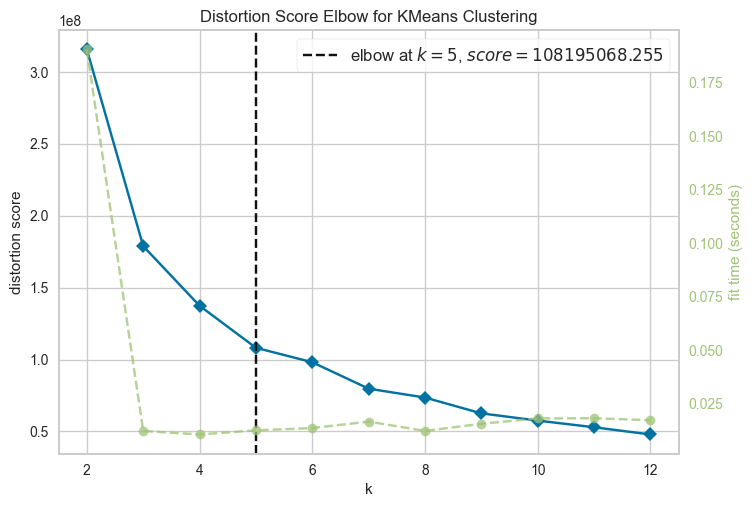

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 13))
visualizer.fit(df_sample_10)
visualizer.show()


Text(0.5, 1.0, 'clusters = 5\nscore = 0.40180863845400233')

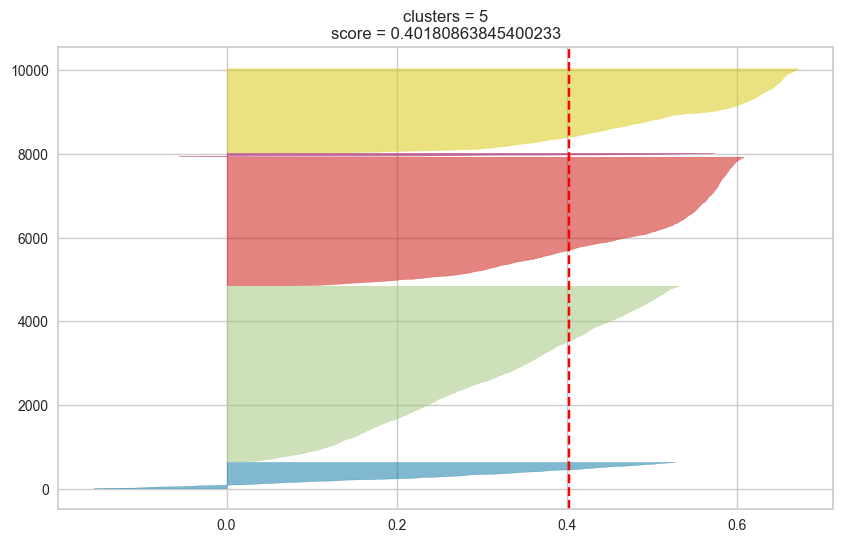

In [9]:
nCluster = 5
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

km = KMeans(n_clusters=nCluster, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax1)
visualizer.fit(df_sample_10)
ax1.set_title(f"clusters = {nCluster}\nscore = {visualizer.silhouette_score_}") 

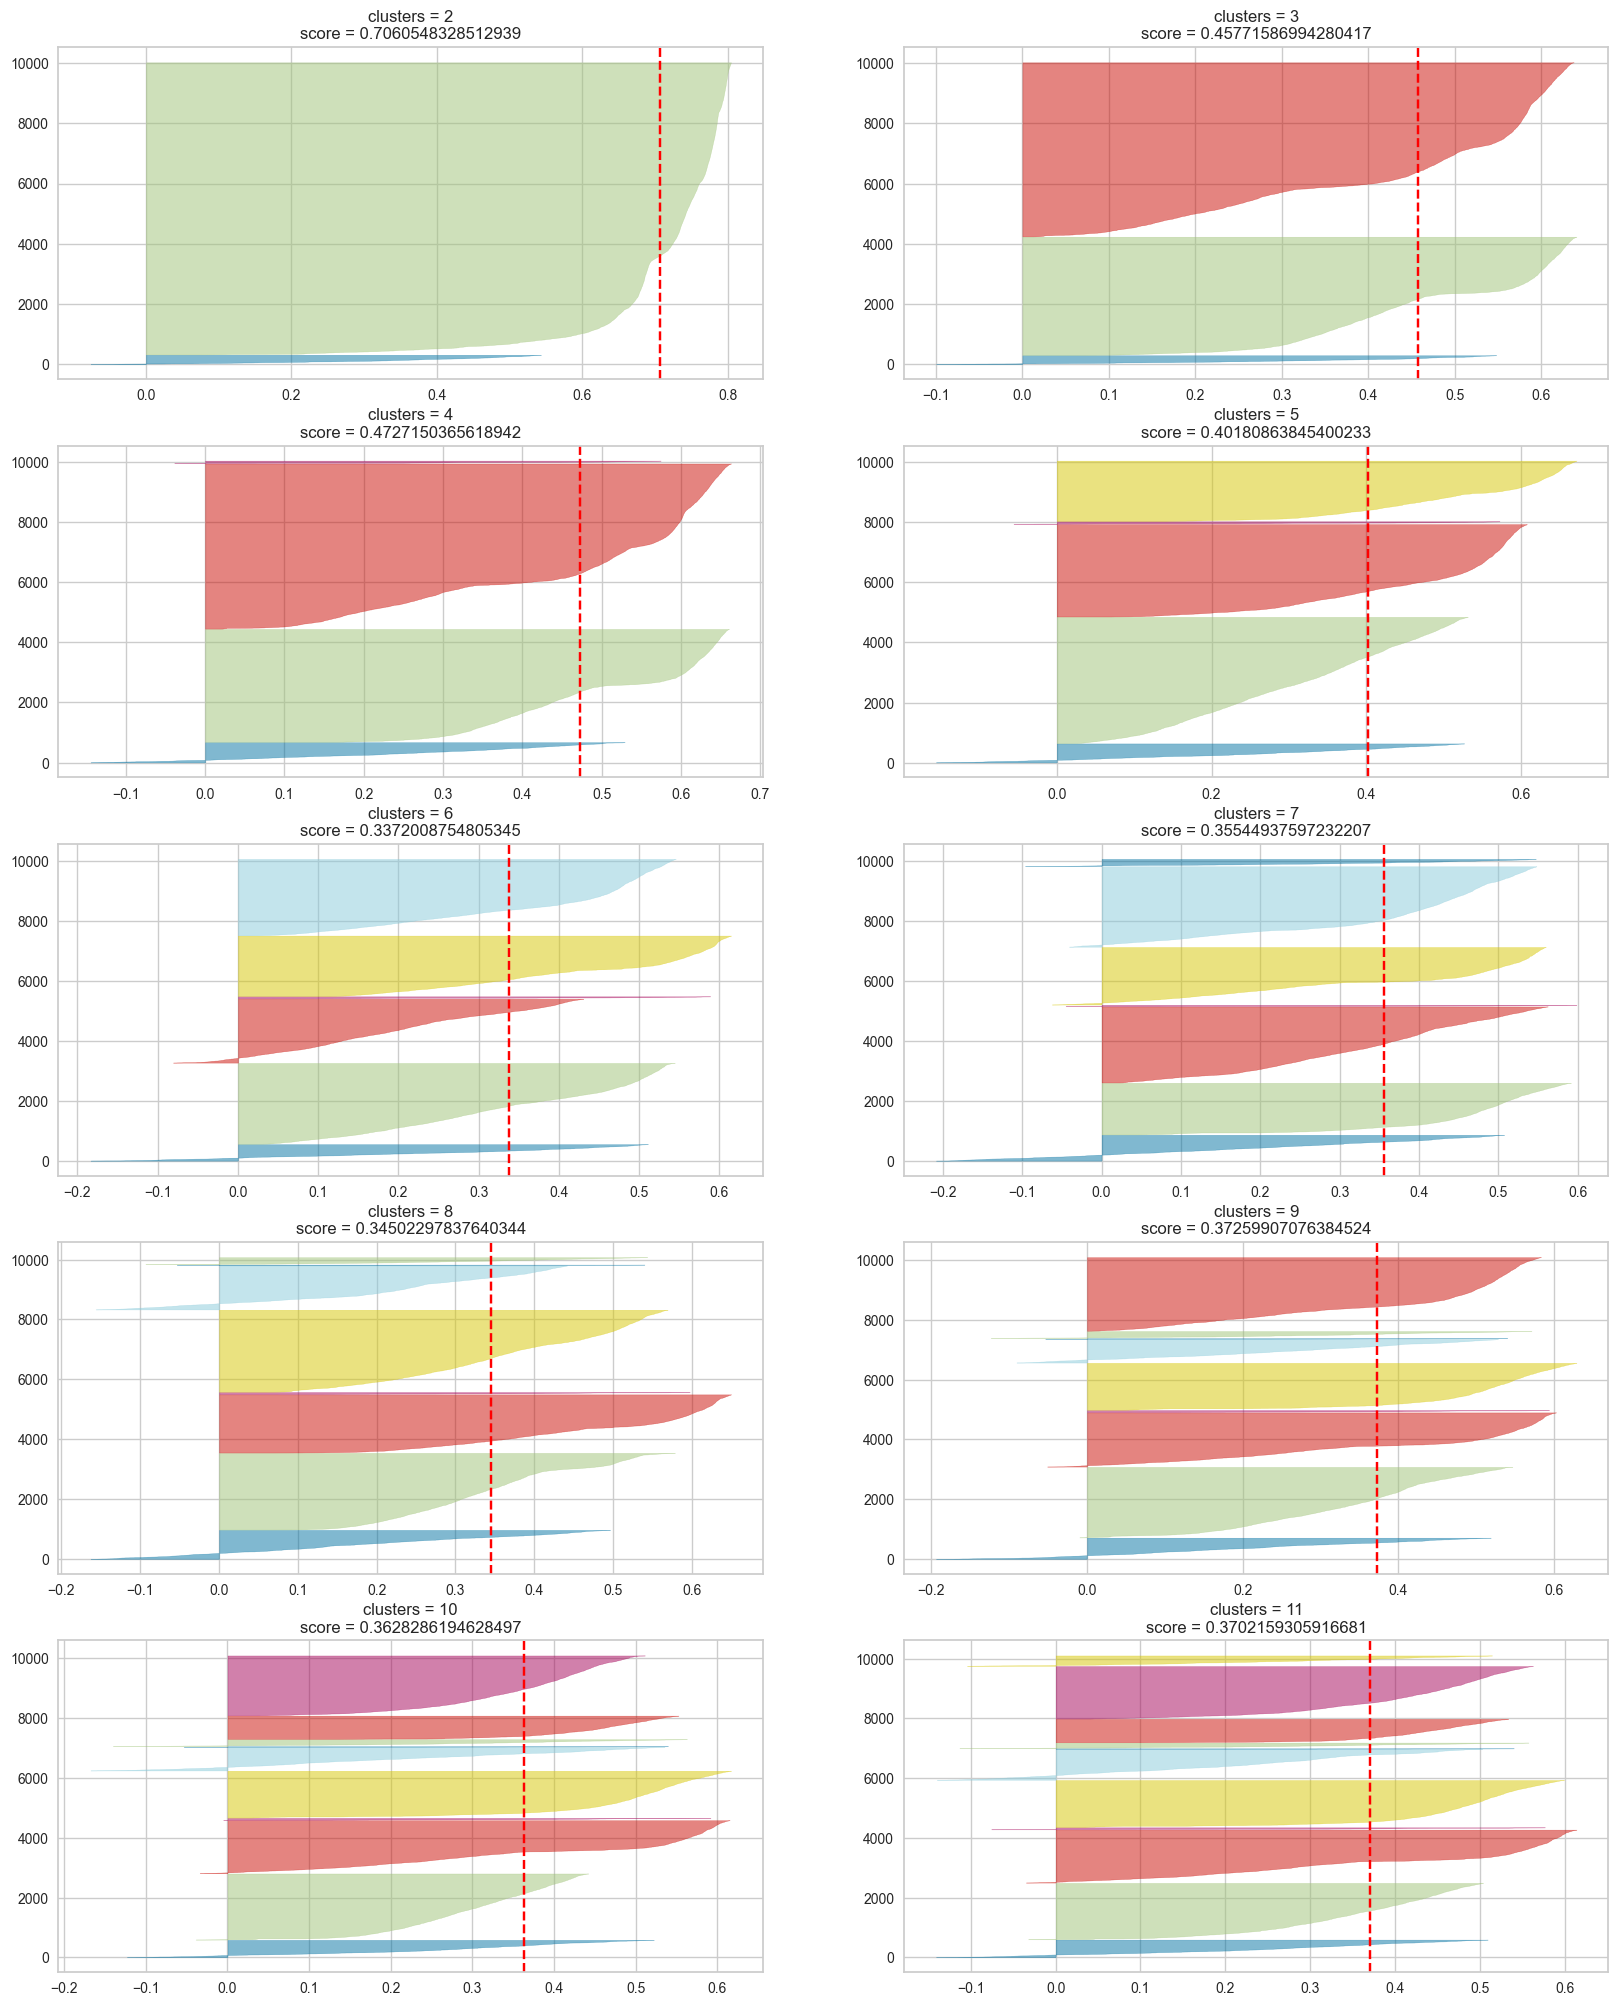

In [10]:
initRange=2
endRange=12

fig, ax = plt.subplots(5, 2, figsize=(20,25))
for nCluster in range(initRange, endRange):
    km = KMeans(n_clusters=nCluster, random_state=42)
    q, mod = divmod(nCluster, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_sample_10)
    ax[q-1][mod].set_title(f"clusters = {nCluster}\nscore = {visualizer.silhouette_score_}") 

fig.savefig(f"./../data_visualization/silhoute_{initRange}_{endRange}_original.png")

### Testando sample de 10000 linhas normalizado

In [11]:
normalizer = MinMaxScaler()
df_sample_10_normalized = normalizer.fit_transform(df_sample_10)

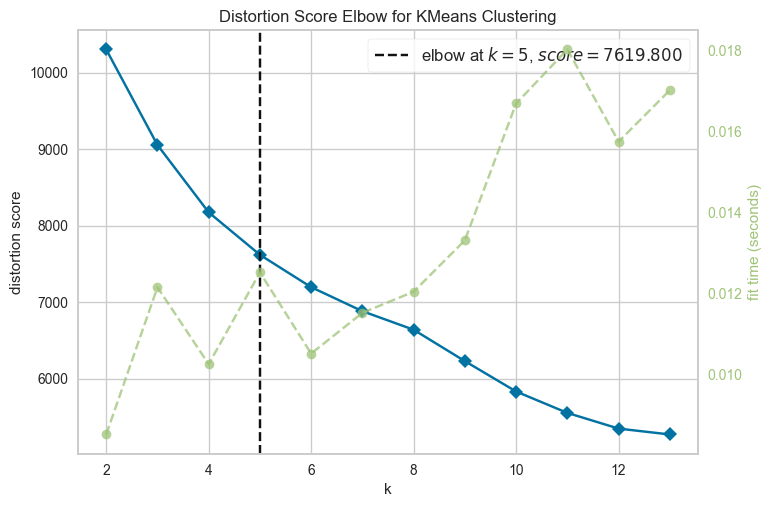

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 14))
visualizer.fit(df_sample_10_normalized)
visualizer.show()

Text(0.5, 1.0, 'clusters normalizado = 5\nscore = 0.18166944077186895')

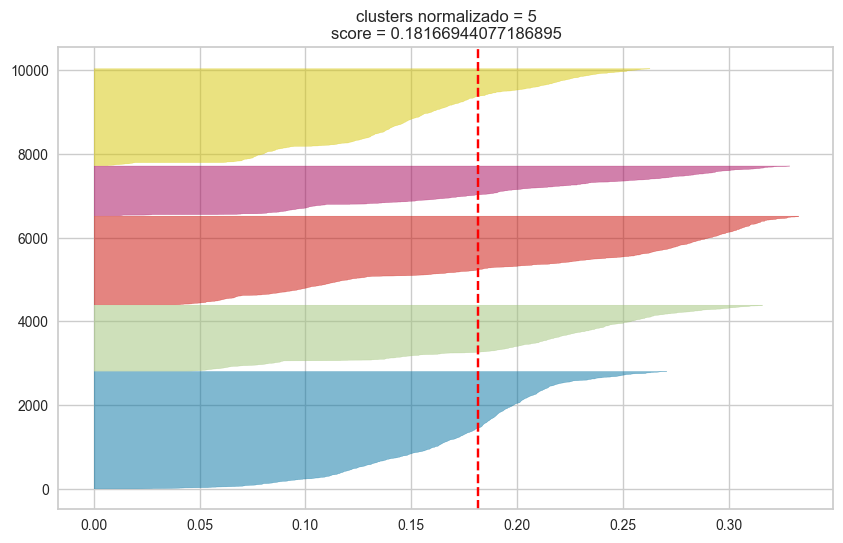

In [13]:
nCluster = 5
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

km = KMeans(n_clusters=nCluster, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax1)
visualizer.fit(df_sample_10_normalized)
ax1.set_title(f"clusters normalizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

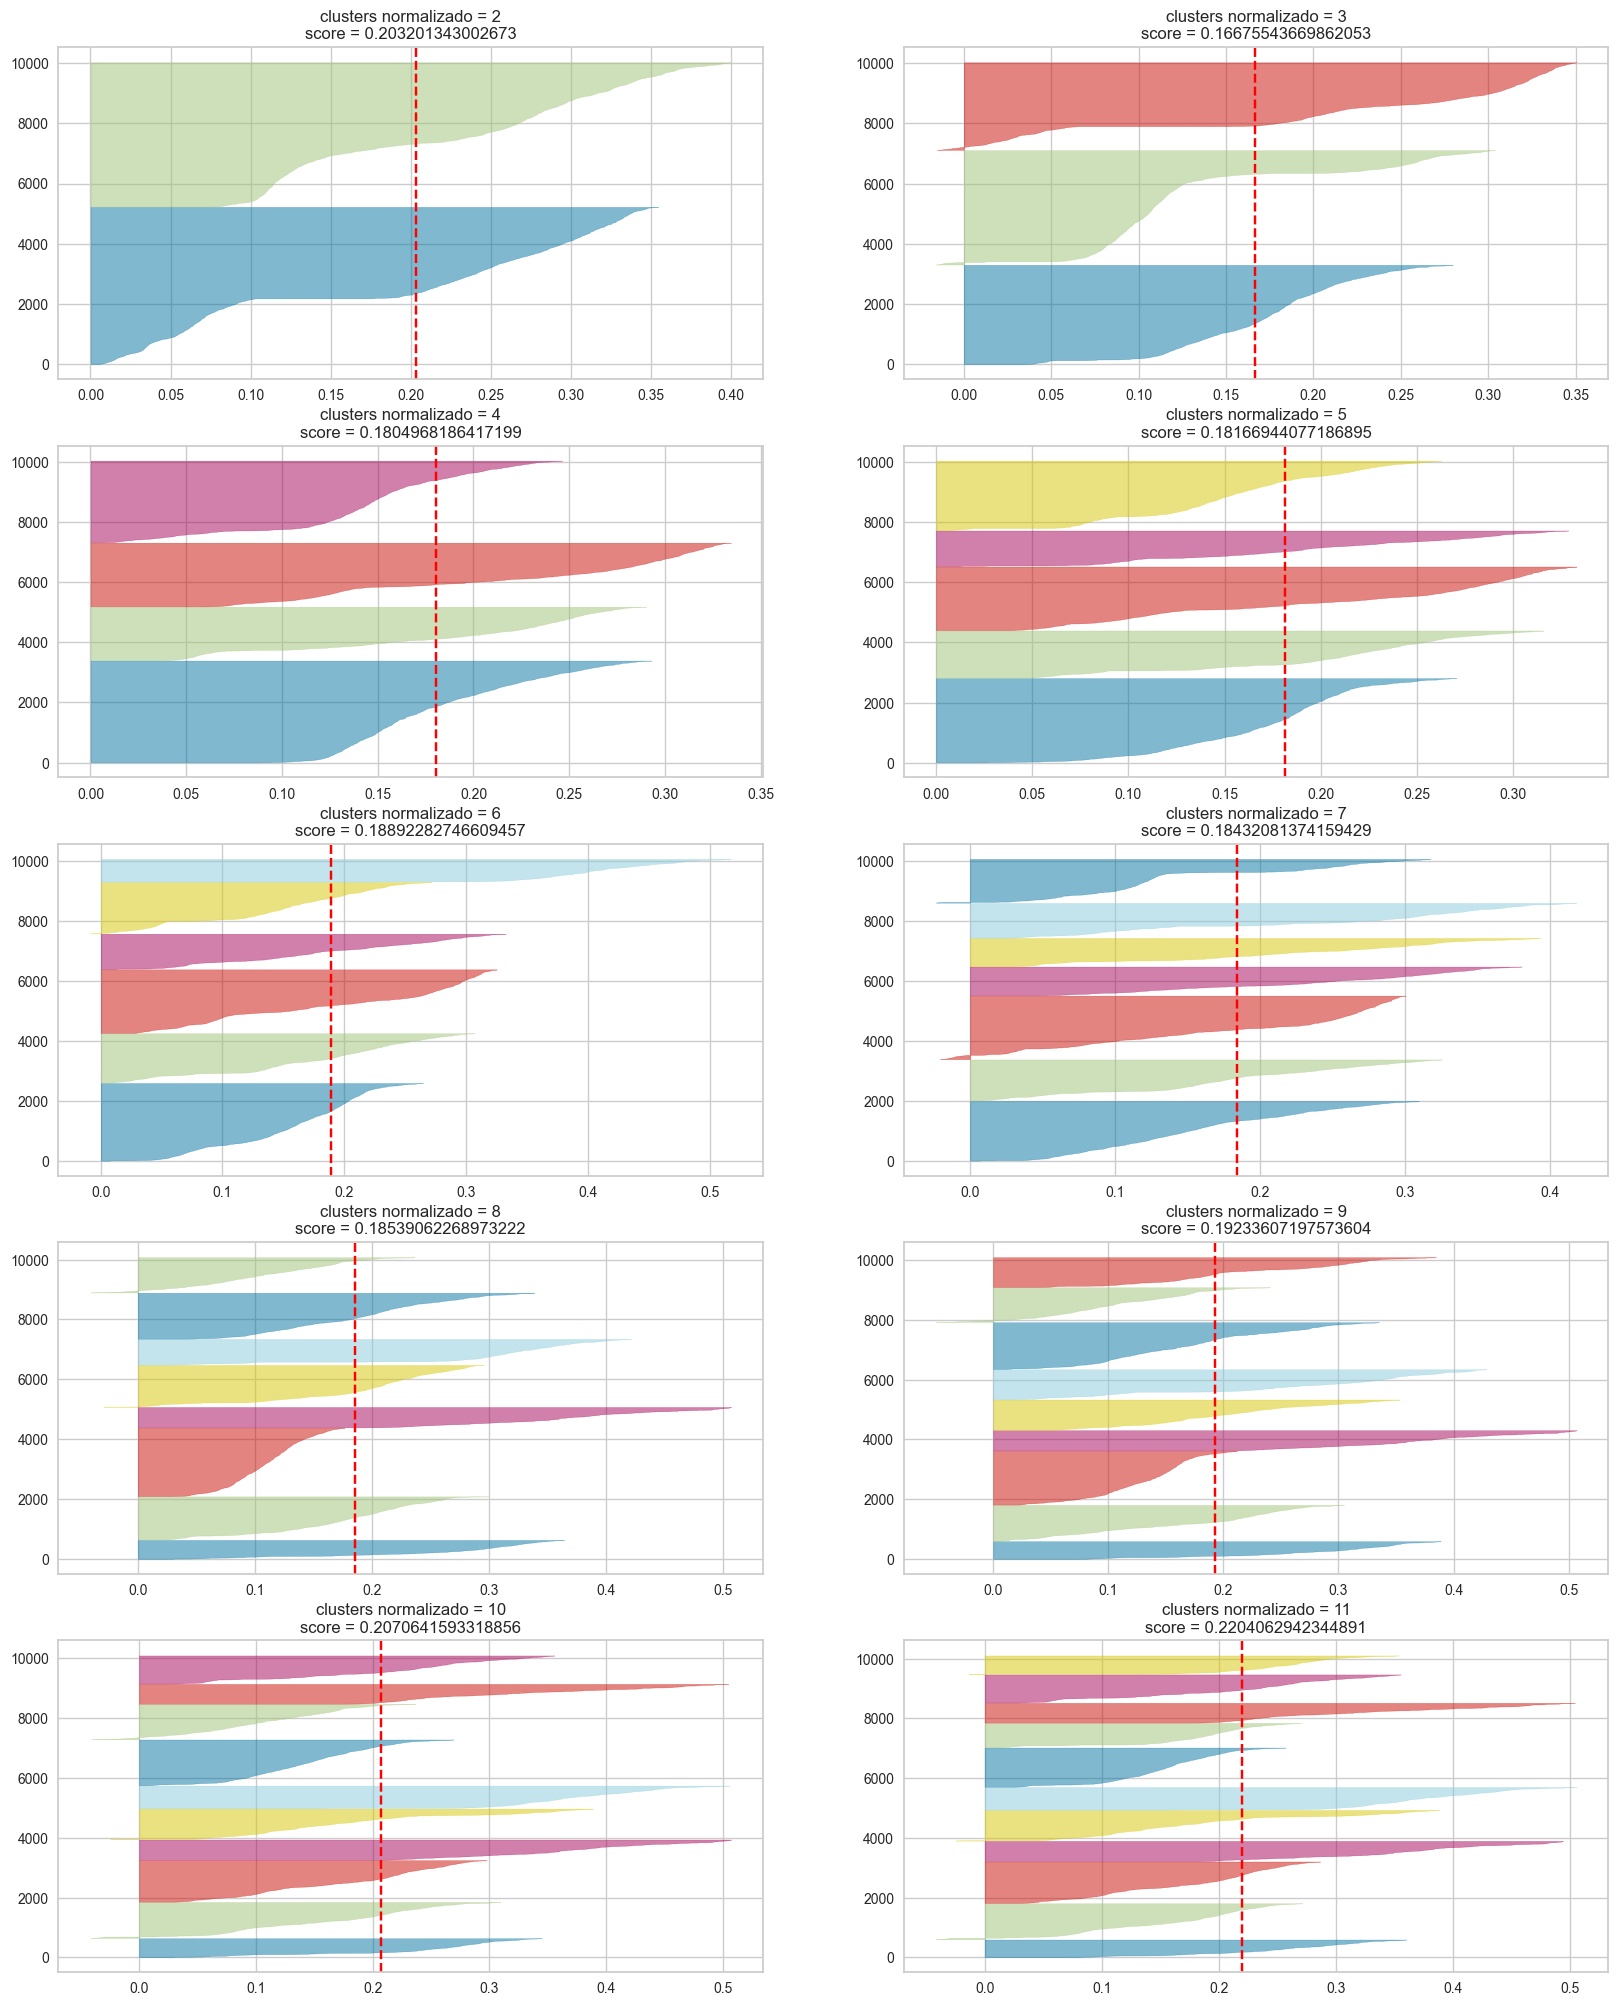

In [14]:
initRange=2
endRange=12

fig, ax = plt.subplots(5, 2, figsize=(20,25))
for nCluster in range(initRange, endRange):
    km = KMeans(n_clusters=nCluster, random_state=42)
    q, mod = divmod(nCluster, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_sample_10_normalized)
    ax[q-1][mod].set_title(f"clusters normalizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

fig.savefig(f"./../data_visualization/silhoute_{initRange}_{endRange}_normalizado.png")

### Testando com sample de 10000 linhas padronizado

In [15]:
scaler = StandardScaler()
df_sample_10_standardized = scaler.fit_transform(df_sample_10)

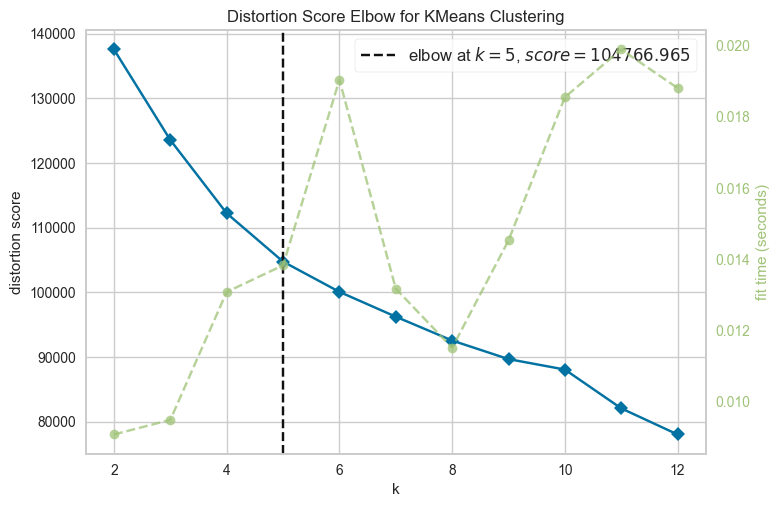

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 13))
visualizer.fit(df_sample_10_standardized)
visualizer.show()

Text(0.5, 1.0, 'clusters padronizado = 5\nscore = 0.16660679500796977')

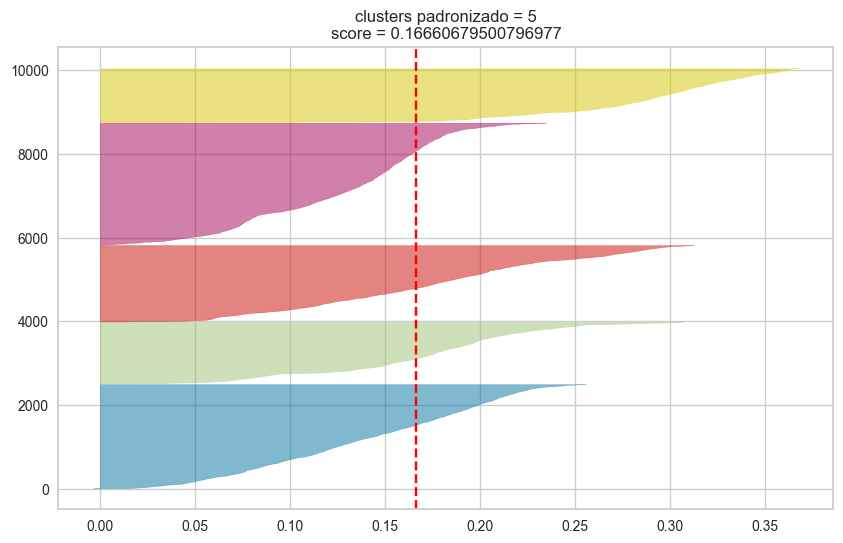

In [17]:
nCluster = 5
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

km = KMeans(n_clusters=nCluster, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax1)
visualizer.fit(df_sample_10_standardized)
ax1.set_title(f"clusters padronizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

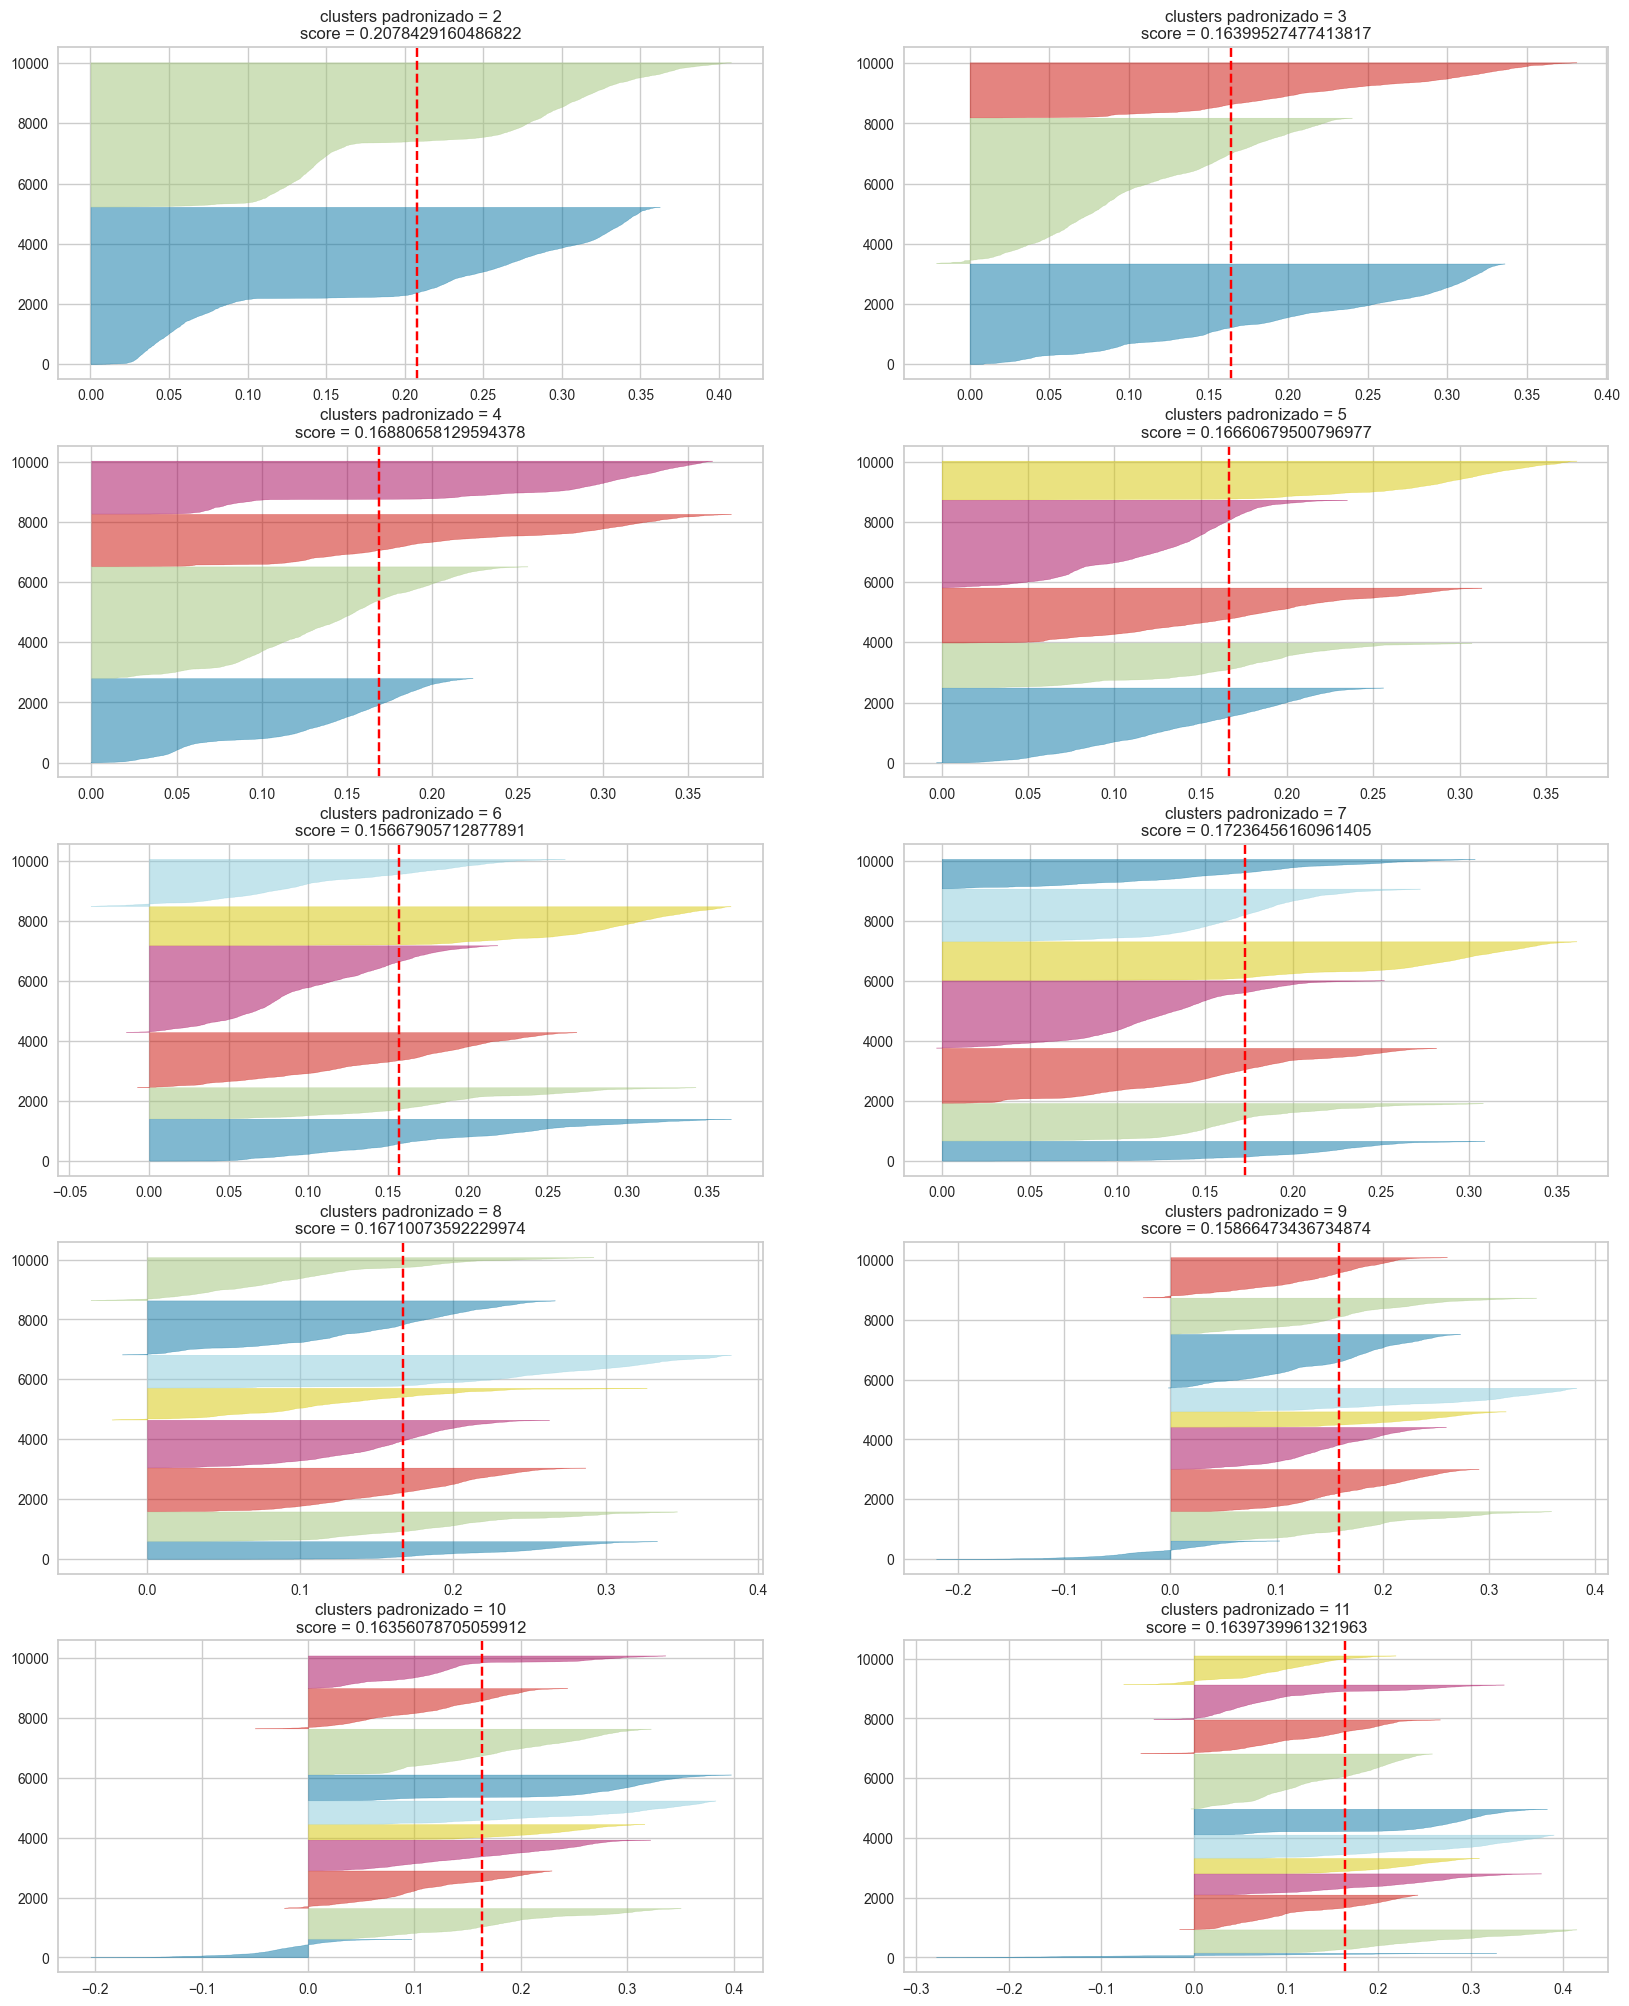

In [18]:
initRange=2
endRange=12

fig, ax = plt.subplots(5, 2, figsize=(20,25))
for nCluster in range(initRange, endRange):
    km = KMeans(n_clusters=nCluster, random_state=42)
    q, mod = divmod(nCluster, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_sample_10_standardized)
    ax[q-1][mod].set_title(f"clusters padronizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

fig.savefig(f"./../data_visualization/silhoute_{initRange}_{endRange}_padronizado.png")

## Seguindo com o dataframe normalizado. Buscando melhor número de clusters

In [19]:
normalizer = MinMaxScaler()
df_nparray_normalized = normalizer.fit_transform(df_cluster)

df_normalized = pd.DataFrame({f'{df_cluster.columns[i]}': df_nparray_normalized[:,i] for i in range(df_nparray_normalized.shape[1])})
df_normalized

comdate_diff  freight_value     price  \
0          0.661538       0.113454  0.070925   
1          0.061538       0.054457  0.063754   
2          0.230769       0.018990  0.003398   
3          0.753846       0.034417  0.005865   
4          0.600000       0.055092  0.024324   
...             ...            ...       ...   
87848      0.369231       0.050967  0.013258   
87849      0.538462       0.034564  0.028020   
87850      0.600000       0.046475  0.008823   
87851      0.169231       0.053871  0.169501   
87852      0.400000       0.018990  0.003152   

       days_since_year_start_commercial  days_since_month_start_commercial  \
0                              0.000000                           0.000000   
1                              0.793296                           0.458333   
2                              0.184358                           0.291667   
3                              0.000000                           0.000000   
4                              0.000000                           0.000000   
...                                 ...                                ...   
87848                          1.000000                           1.000000   
87849                          0.251397                           0.000000   
87850                          0.251397                           0.000000   
87851                          0.913408                           0.958333   
87852                          1.000000                           1.000000   

       year_commercial  month_commercial  day_of_month_commercial  \
0                  1.0          0.000000                 0.000000   
1                  0.5          0.818182                 0.458333   
2                  1.0          0.181818                 0.291667   
3                  1.0          0.000000                 0.000000   
4                  1.0          0.000000                 0.000000   
...                ...               ...                      ...   
87848              0.5          1.000000                 1.000000   
87849              1.0          0.272727                 0.000000   
87850              1.0          0.272727                 0.000000   
87851              0.5          0.909091                 0.958333   
87852              0.5          1.000000                 1.000000   

       day_of_week_commercial  days_since_year_start_purchase  \
0                    0.000000                        0.030220   
1                    0.500000                        0.703297   
2                    0.500000                        0.134615   
3                    0.000000                        0.046703   
4                    0.000000                        0.019231   
...                       ...                             ...   
87848                0.000000                        0.961538   
87849                1.000000                        0.255495   
87850                1.000000                        0.266484   
87851                0.666667                        0.840659   
87852                0.000000                        0.967033   

       days_since_month_start_purchase  year_purchase  month_purchase  \
0                             0.366667            1.0        0.000000   
1                             0.433333            0.5        0.727273   
2                             0.600000            1.0        0.090909   
3                             0.566667            1.0        0.000000   
4                             0.233333            1.0        0.000000   
...                                ...            ...             ...   
87848                         0.533333            0.5        1.000000   
87849                         0.100000            1.0        0.272727   
87850                         0.233333            1.0        0.272727   
87851                         0.066667            0.5        0.909091   
87852                         0.600000            0.5        1.000000   

      

In [ ]:
# random = 42
# initRange = 2
# endRange = 14
# df_cluster = df_normalized
# # df = df_normalized.sample(10000, random_state=random)

# # grafico de cotovelo
# km = KMeans(random_state=random)
# visualizer = KElbowVisualizer(km, k=(initRange, endRange))
# visualizer.fit(df_cluster)
# visualizer.show()

# # graficos de score. Silhoueta, Calinski Harabasz, Davies Bouldin 
# fitted_kmeans = {}
# labels_kmeans = {}
# df_scores = []
# for n_clusters in np.arange(initRange, endRange):
#     tmp_scores = {}
#     tmp_scores["n_clusters"] = n_clusters
    
#     kmeans = KMeans(n_clusters=n_clusters, random_state=random)
#     labels_clusters = kmeans.fit_predict(df_cluster)
    
#     fitted_kmeans[n_clusters] = kmeans
#     labels_kmeans[n_clusters] = labels_clusters
    
#     silhouette = silhouette_score(df_cluster, labels_clusters)
#     tmp_scores["silhouette_score"] = silhouette
#     ch = calinski_harabasz_score(df_cluster, labels_clusters)
#     tmp_scores["calinski_harabasz_score"] = ch
#     db = davies_bouldin_score(df_cluster, labels_clusters)
#     tmp_scores["davies_bouldin_score"] = db
                
#     df_scores.append(tmp_scores)

# df_scores = pd.DataFrame(df_scores)
# df_scores.set_index("n_clusters", inplace=True)
# df_scores.plot(subplots=True, layout=(1,3), figsize=(15, 5))

# # Grafico de silhoueta com 8 clusters
# nCluster = 8
# fig, (ax1) = plt.subplots(1, 1)
# fig.set_size_inches(10, 5)
# km = KMeans(n_clusters=nCluster, random_state=42)
# visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax1)
# visualizer.fit(df_cluster)
# ax1.set_title(f"clusters normalizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

In [ ]:
## Célula com longo tempo pra executar

# initRange=2
# endRange=14

# fig, ax = plt.subplots(4, 3, figsize=(22,20))
# for nCluster in range(initRange, endRange):
#     km = KMeans(n_clusters=nCluster, random_state=42)
#     q, mod = divmod(nCluster, 3)
#     visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
#     visualizer.fit(df_normalized)
#     ax[q-1][mod].set_title(f"clusters normalizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

## Clusterizando

### KMeans
### Utilizando 5

In [21]:
n_clusters = 5
kmeans_model = KMeans(n_clusters, random_state=42)
clusters = kmeans_model.fit_predict(df_normalized)
df_kmeans = pd.DataFrame(clusters)
df_normalized.insert(df_normalized.shape[1], f'kmeans_{n_clusters}', df_kmeans)
df_normalized

df_cluster["kmeans_5"] = df_normalized["kmeans_5"]
df_cluster

comdate_diff  freight_value   price  days_since_year_start_commercial  \
0                11          46.48  289.00                                 0   
1               -28          22.31  259.90                               284   
2               -17           7.78   14.99                                66   
3                17          14.10   25.00                                 0   
4                 7          22.57   99.90                                 0   
...             ...            ...     ...                               ...   
87848            -8          20.88   55.00                               358   
87849             3          14.16  114.90                                90   
87850             7          19.04   37.00                                90   
87851           -21          22.07  689.00                               327   
87852            -6           7.78   13.99                               358   

       days_since_month_start_commercial  year_commercial  month_commercial  \
0                                      0             2018                 1   
1                                     11             2017                10   
2                                      7             2018                 3   
3                                      0             2018                 1   
4                                      0             2018                 1   
...                                  ...              ...               ...   
87848                                 24             2017                12   
87849                                  0             2018                 4   
87850                                  0             2018                 4   
87851                                 23             2017                11   
87852                                 24             2017                12   

       day_of_month_commercial  day_of_week_commercial  \
0                            1                       0   
1                           12                       3   
2                            8                       3   
3                            1                       0   
4                            1                       0   
...                        ...                     ...   
87848                       25                       0   
87849                        1                       6   
87850                        1                       6   
87851                       24                       4   
87852                       25                       0   

       days_since_year_start_purchase  days_since_month_start_purchase  \
0                                  11                               11   
1                                 256                               13   
2                                  49                               18   
3                                  17                               17   
4                                   7                                7   
...                               ...                              ...   
87848                             350                               16   
87849                              93                                3   
87850                              97                                7   
87851                             306                                2   
87852                             352                               18   

       year_purchase  month_purchase  day_of_month_purchase  \
0               2018               1                     12   
1               2017               9                     14   
2               2018               2                     19   
3               2018               1                     18   
4               2018               1                      8   
...              ...             ...                    ...   
87848           2017              12                     17   
87849  

## EDA geral

### EDA para kmeans de 5
### Todas as features

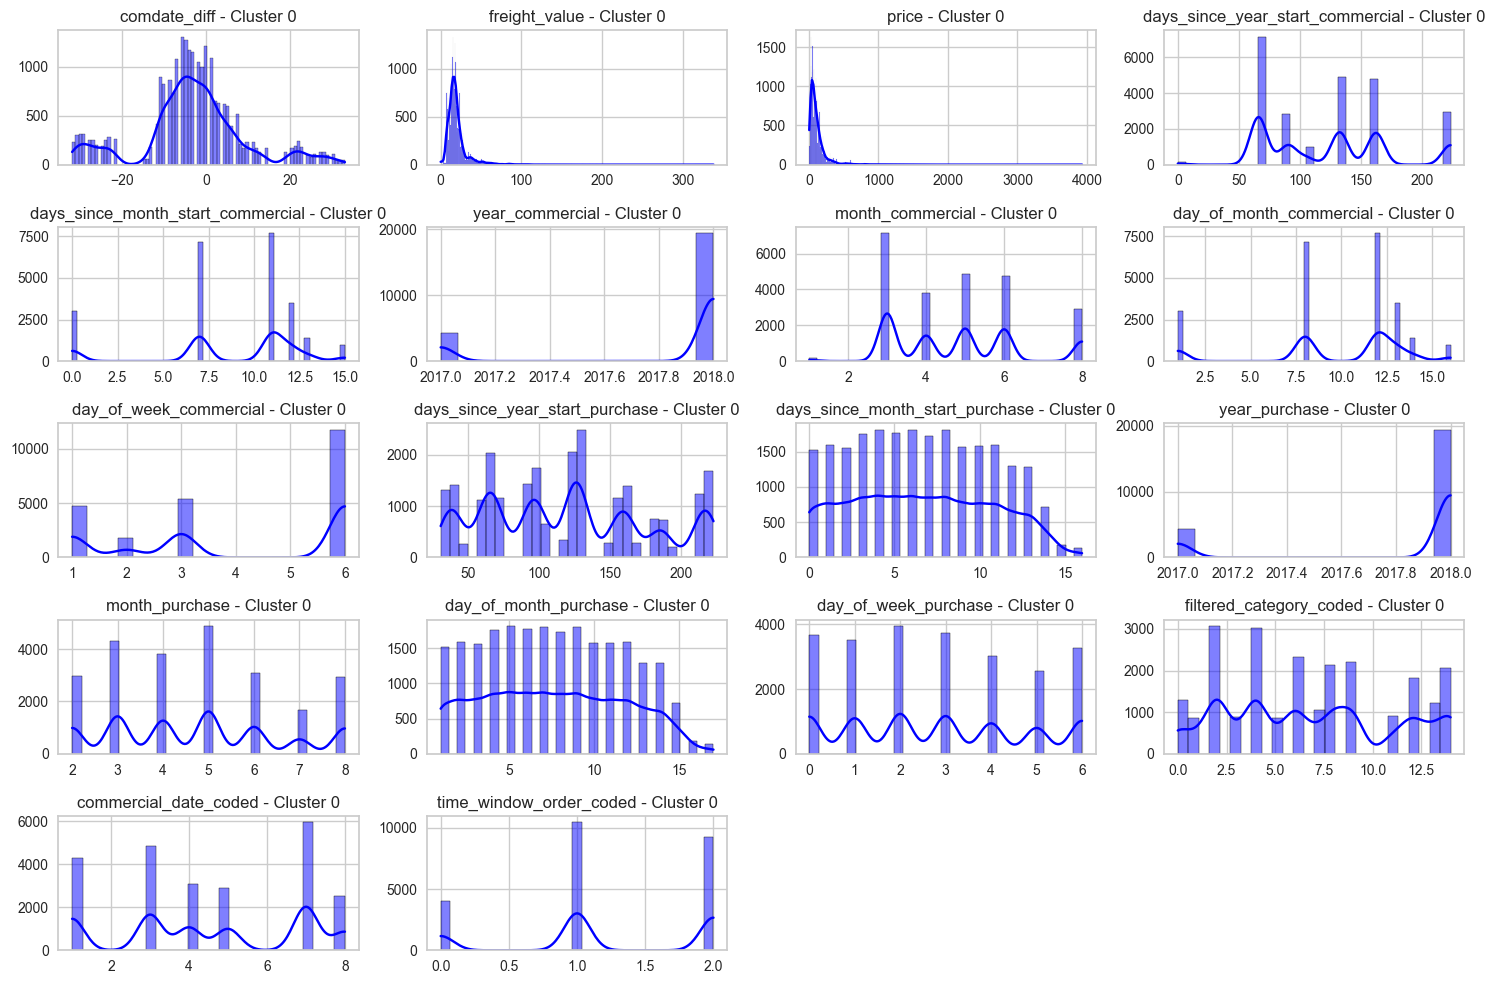

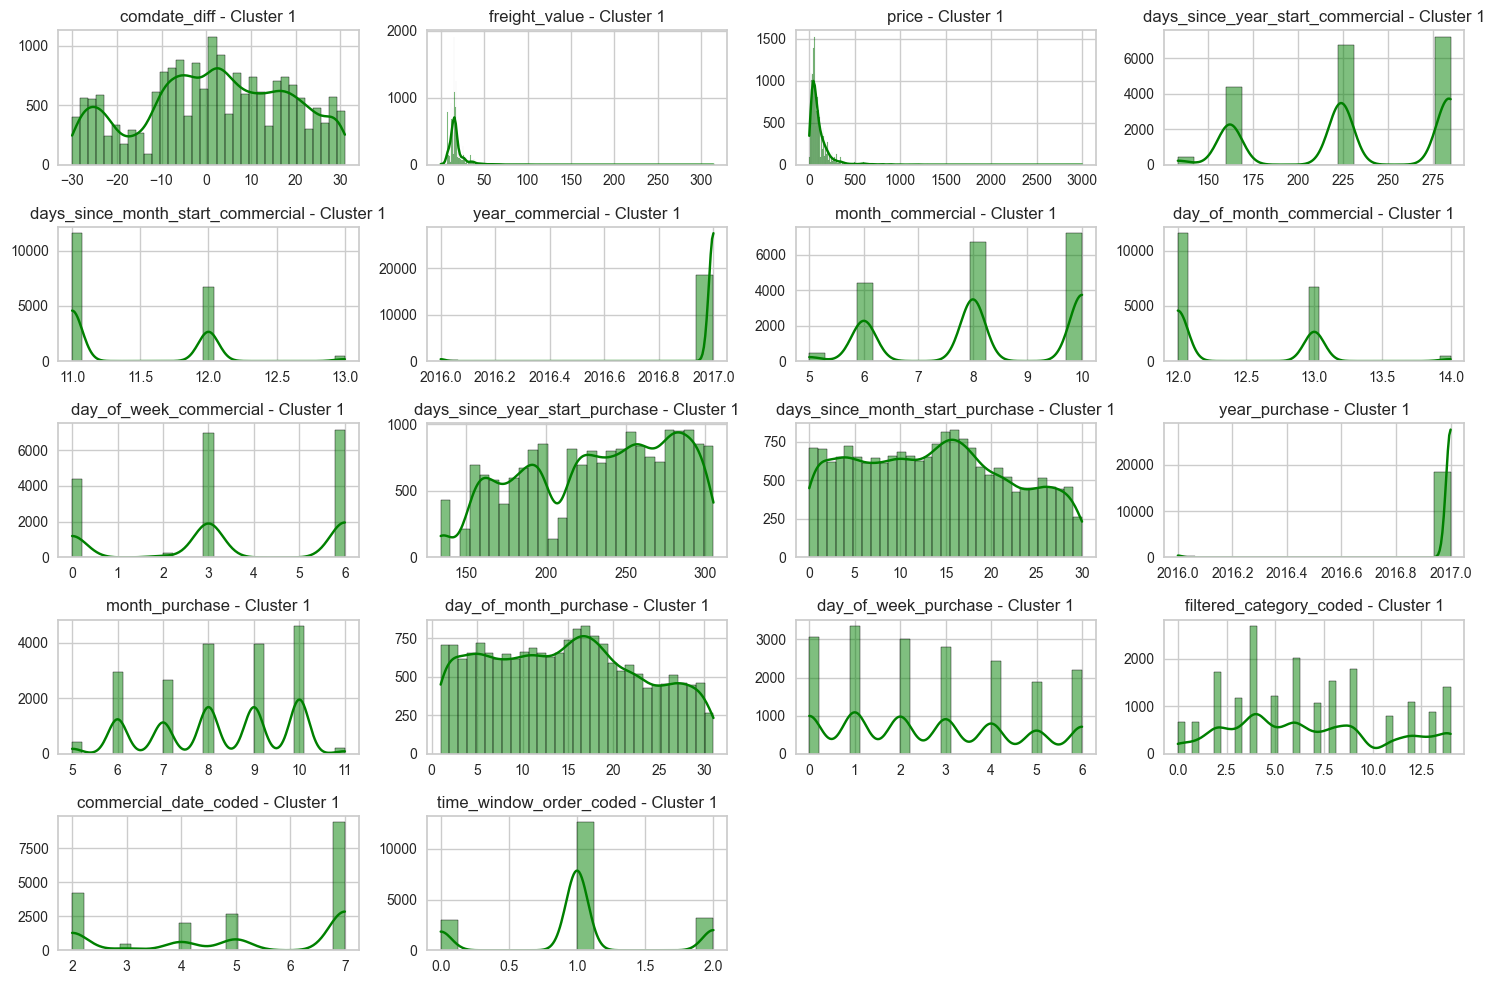

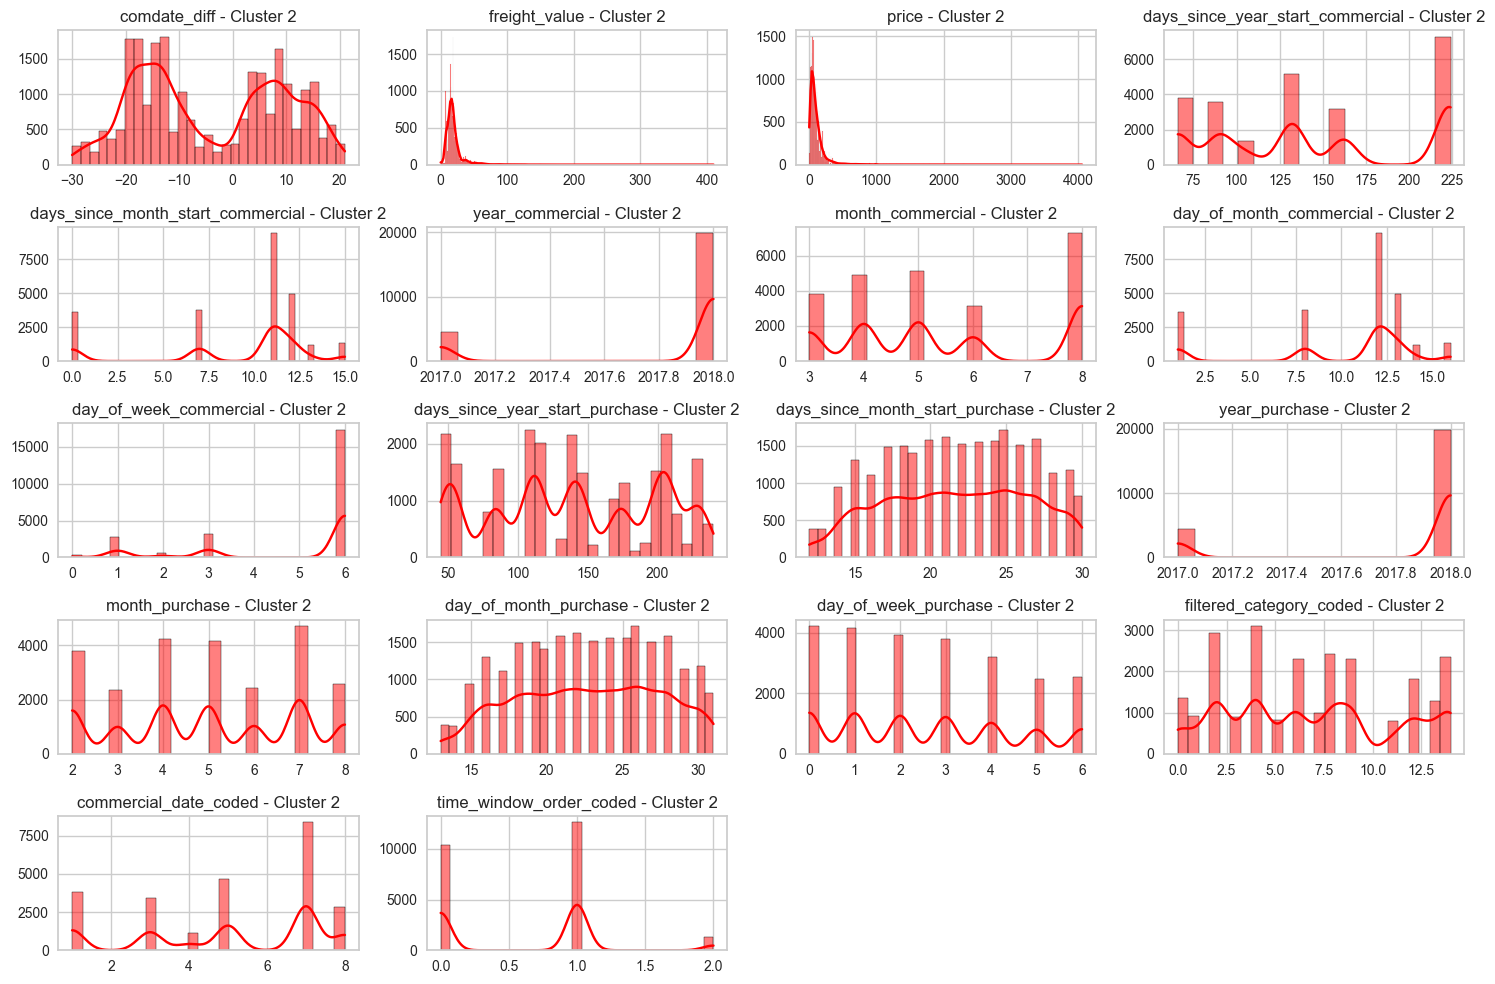

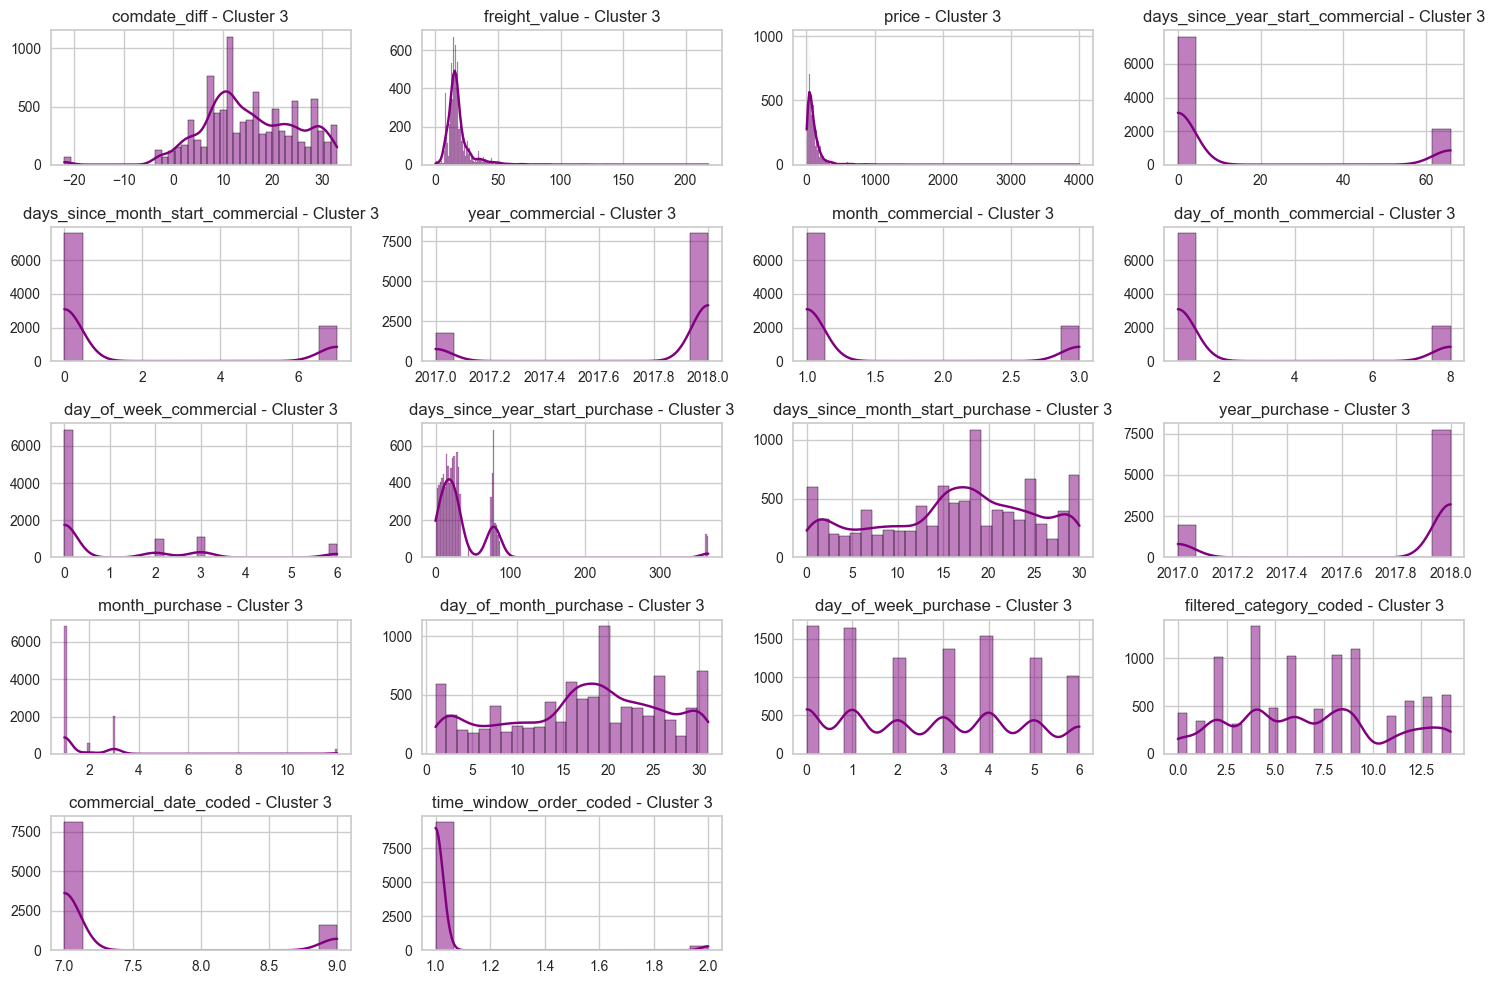

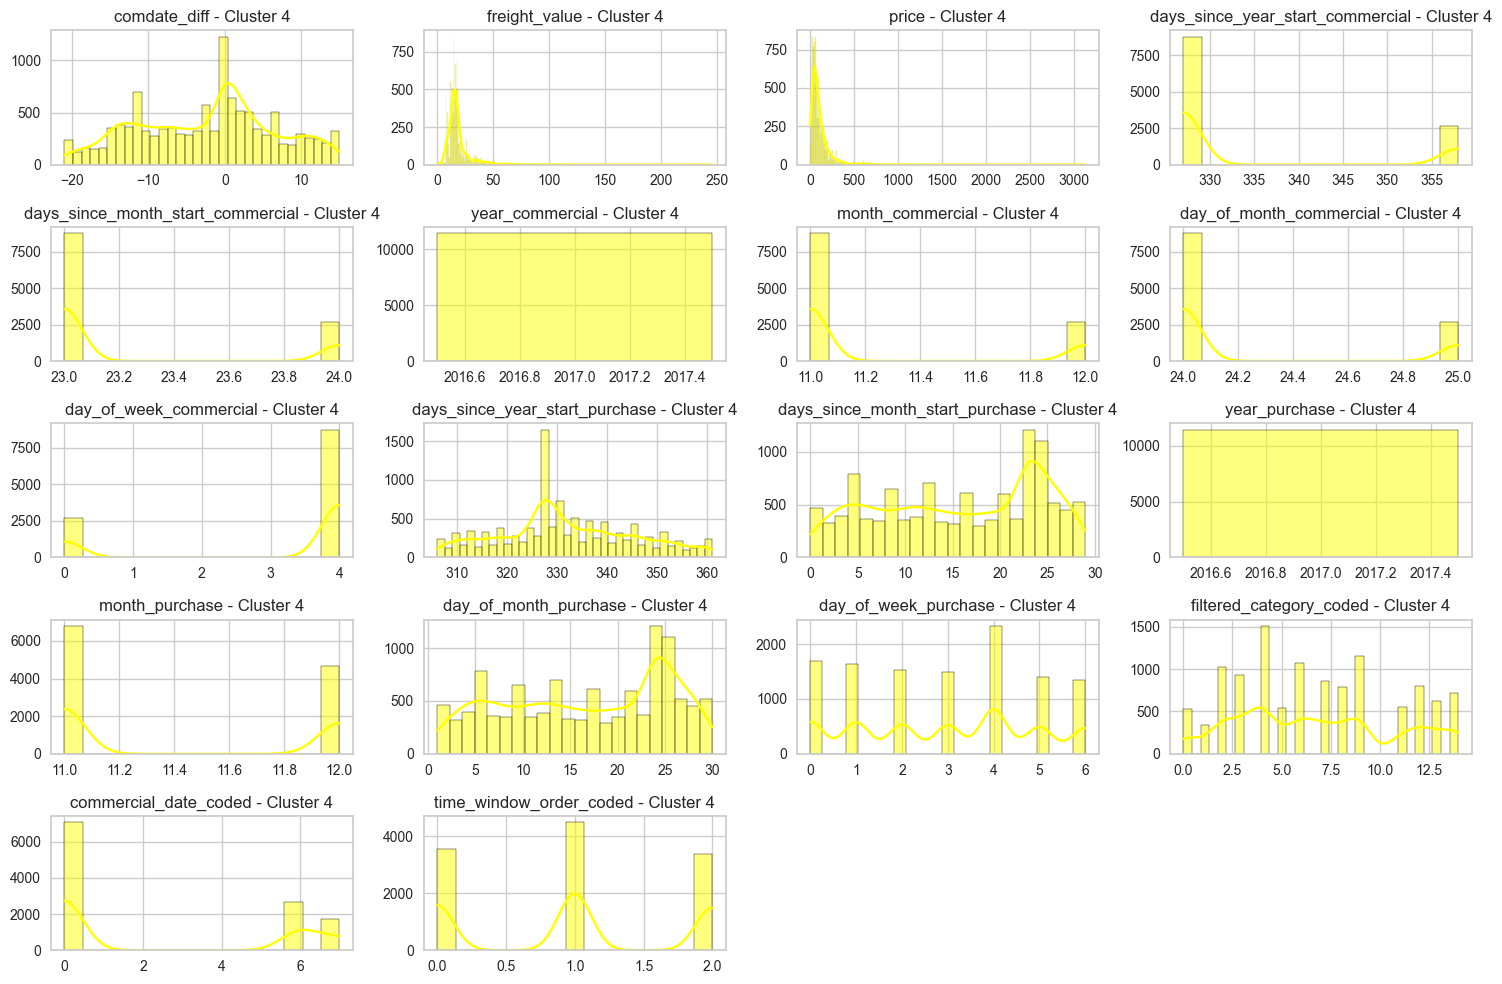

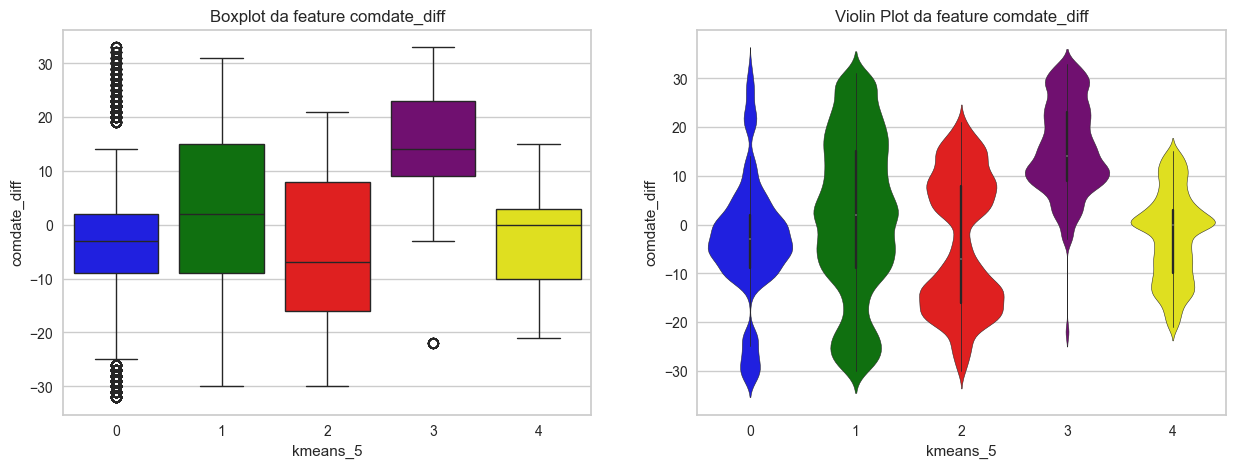

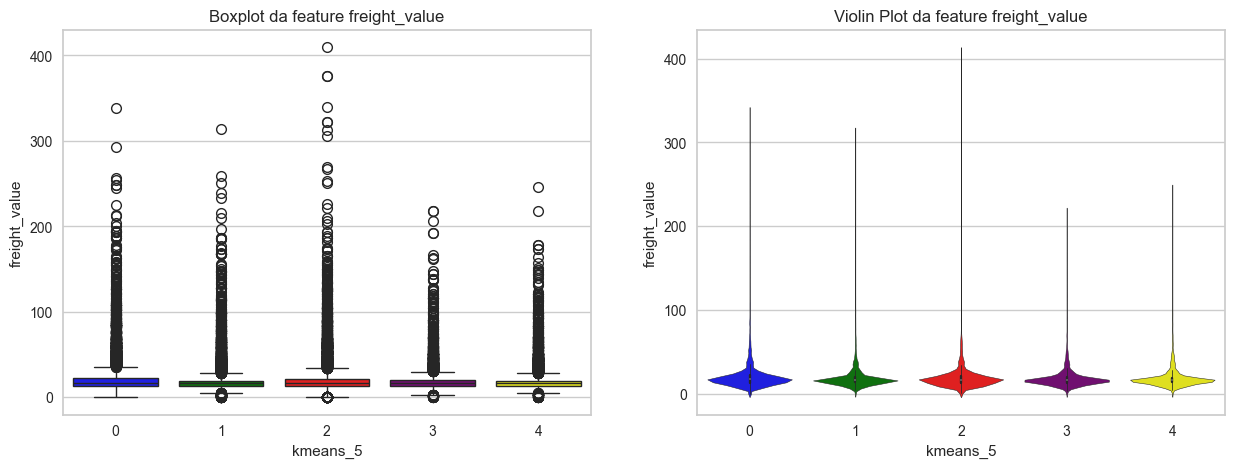

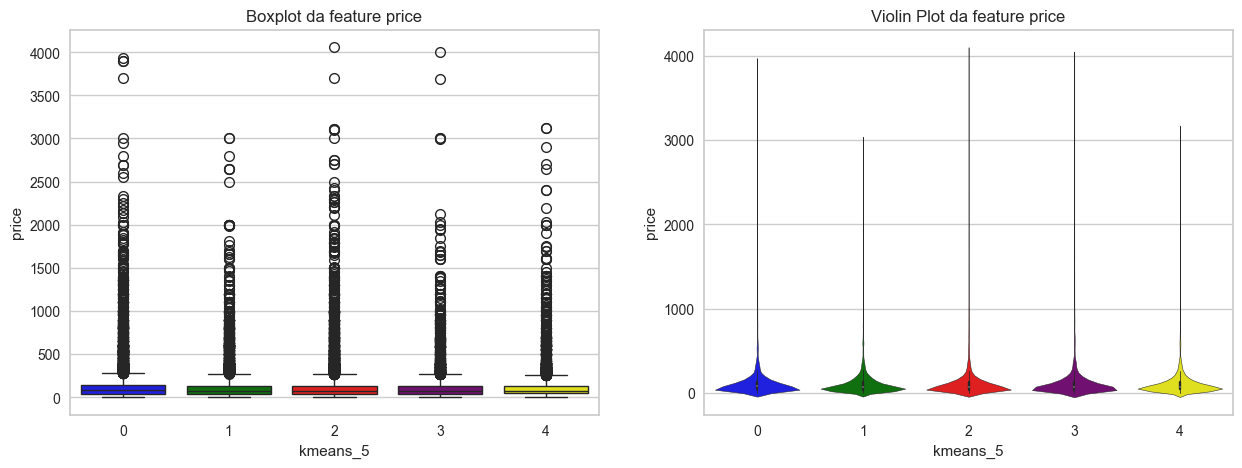

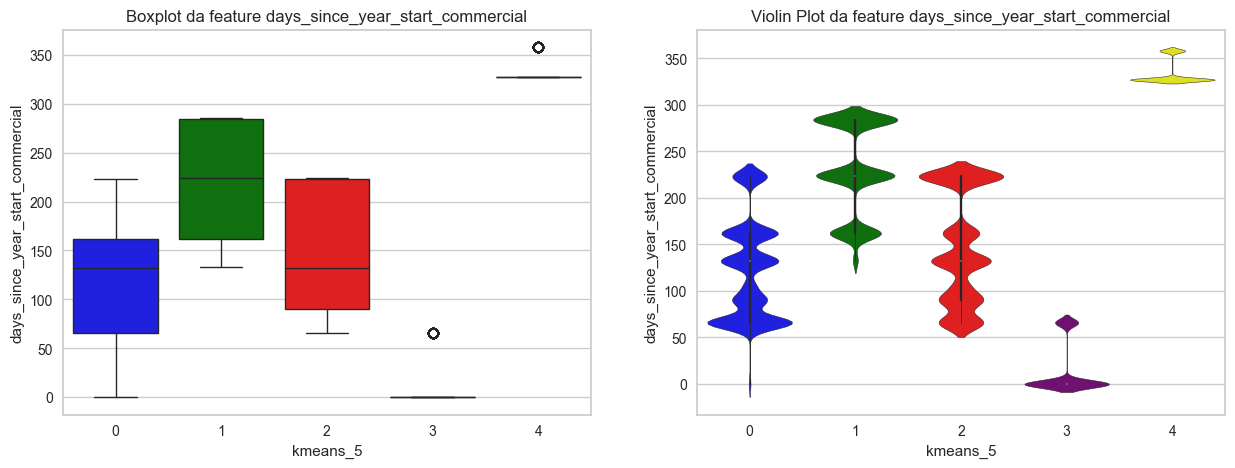

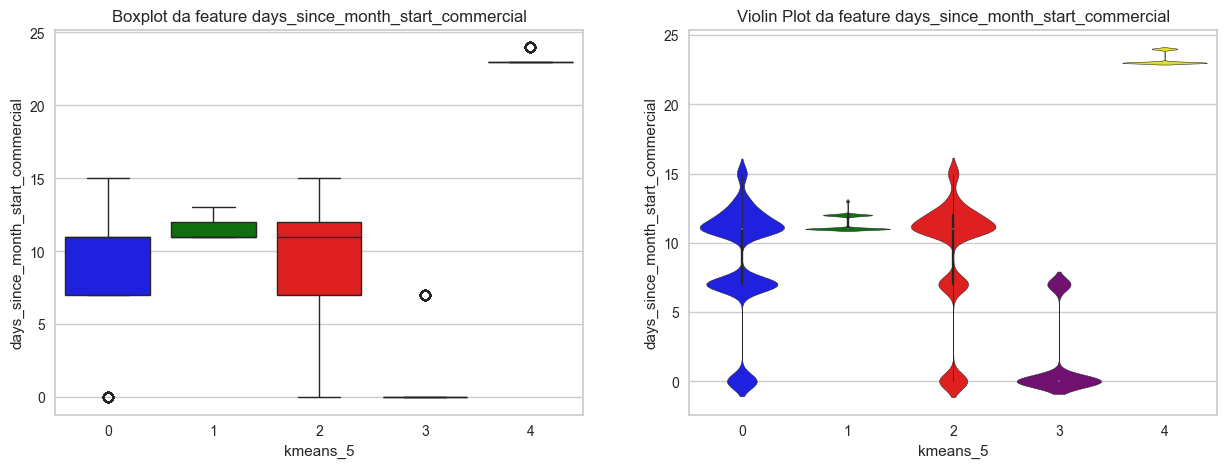

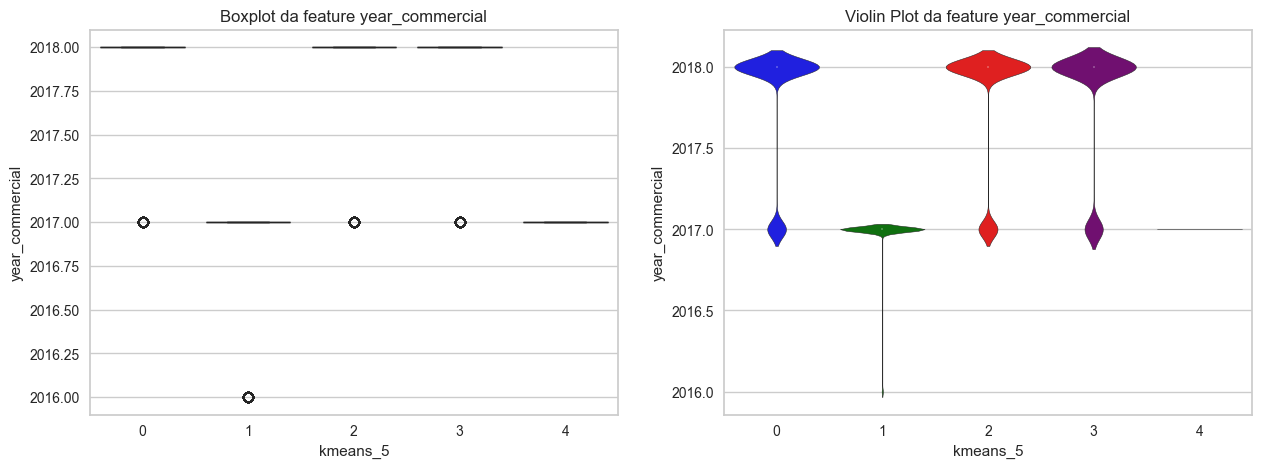

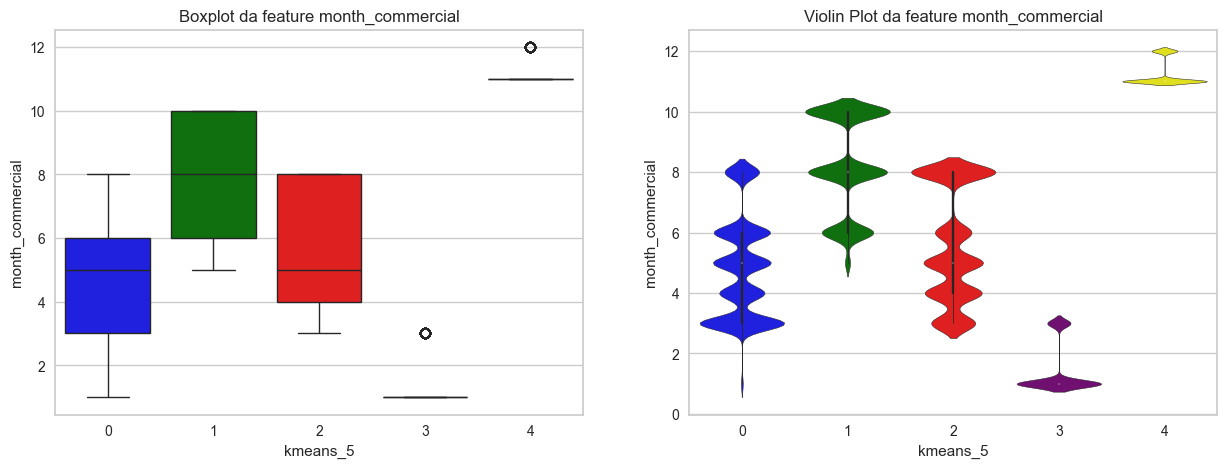

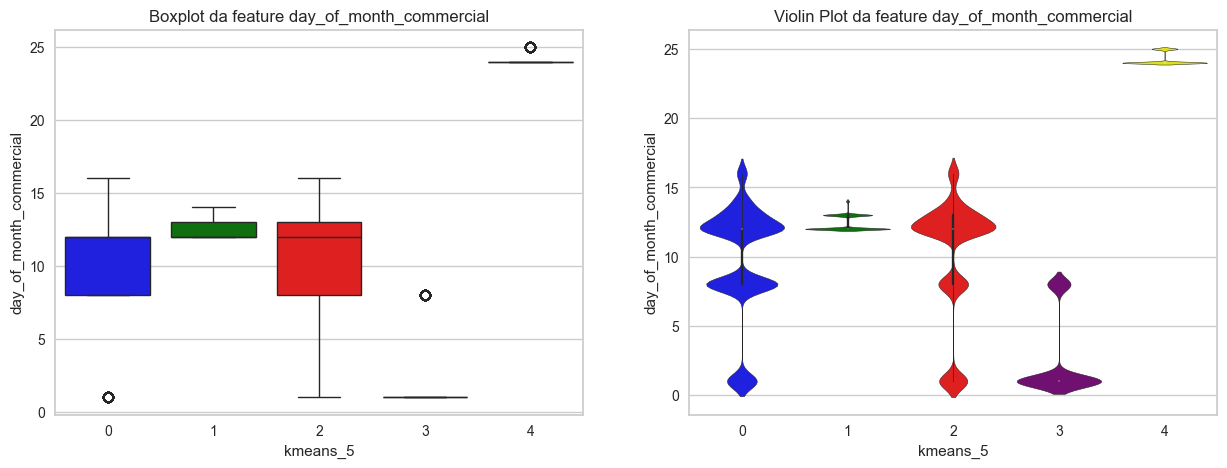

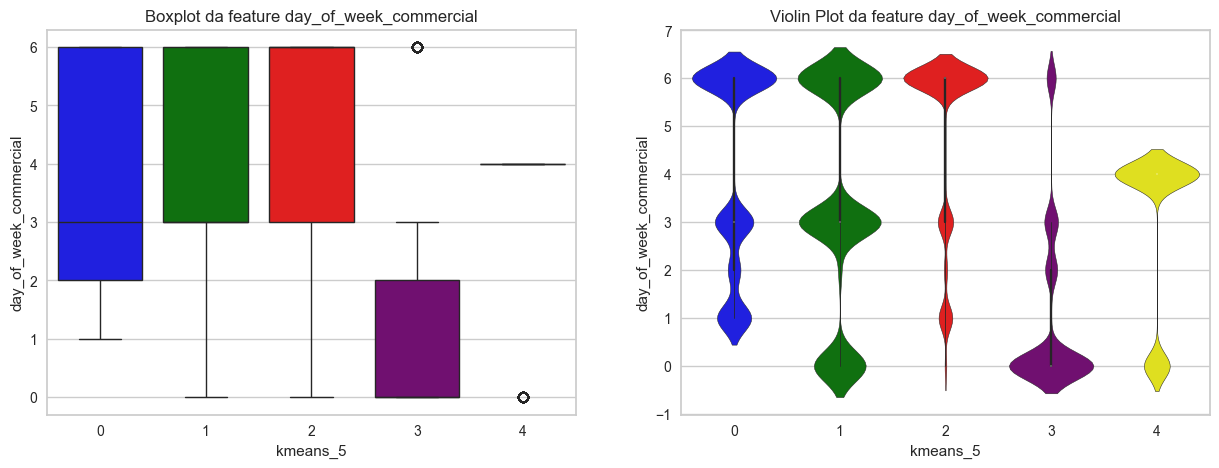

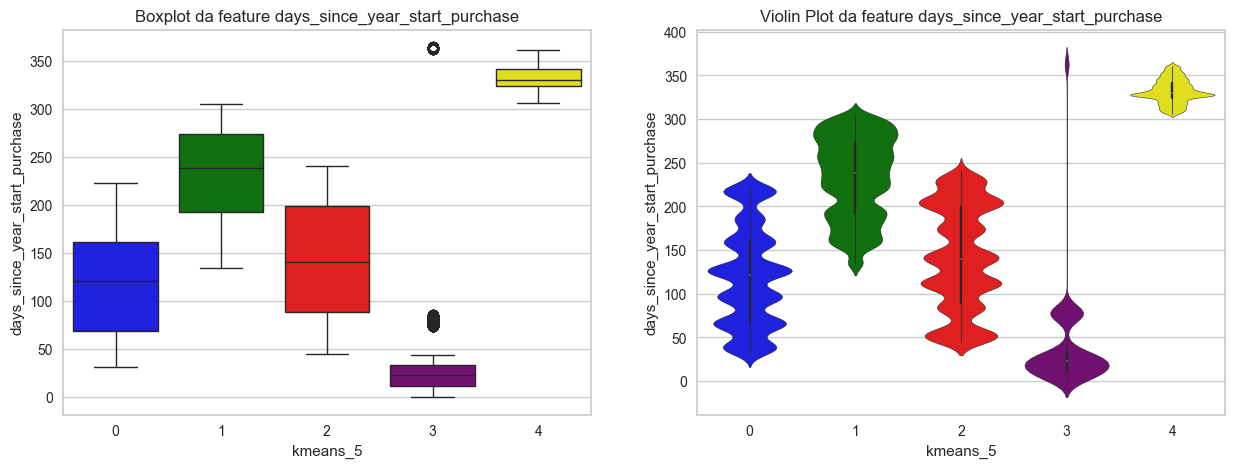

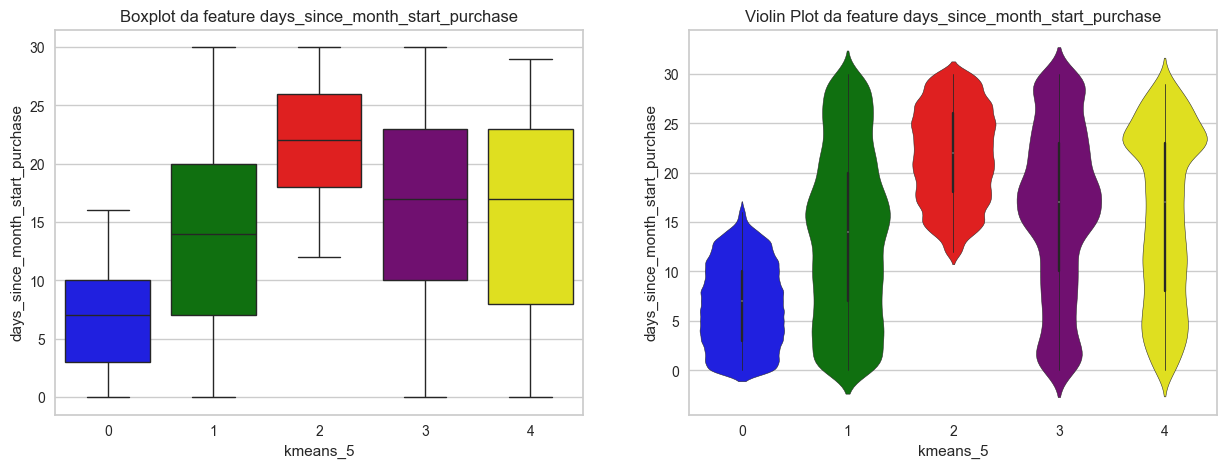

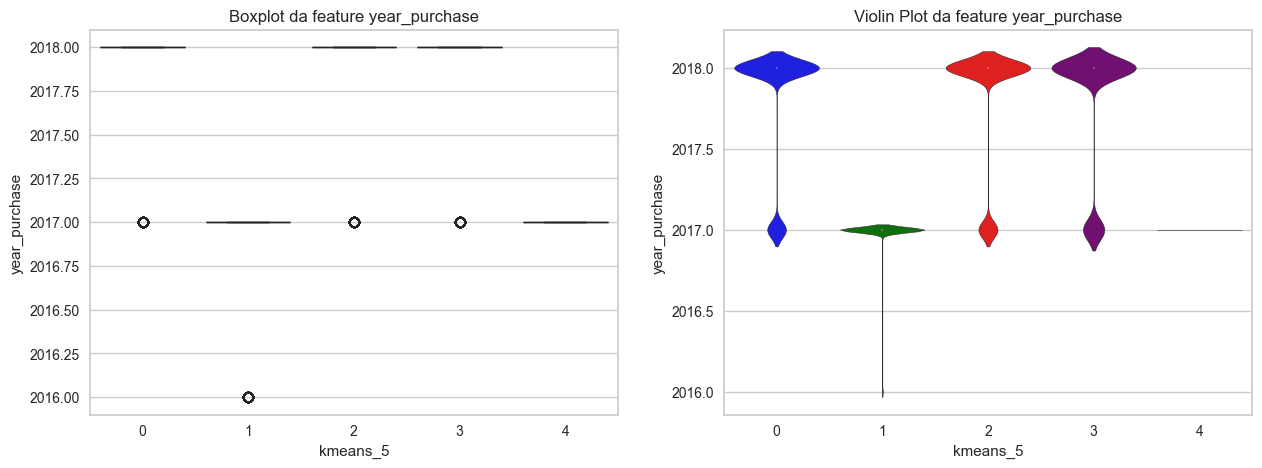

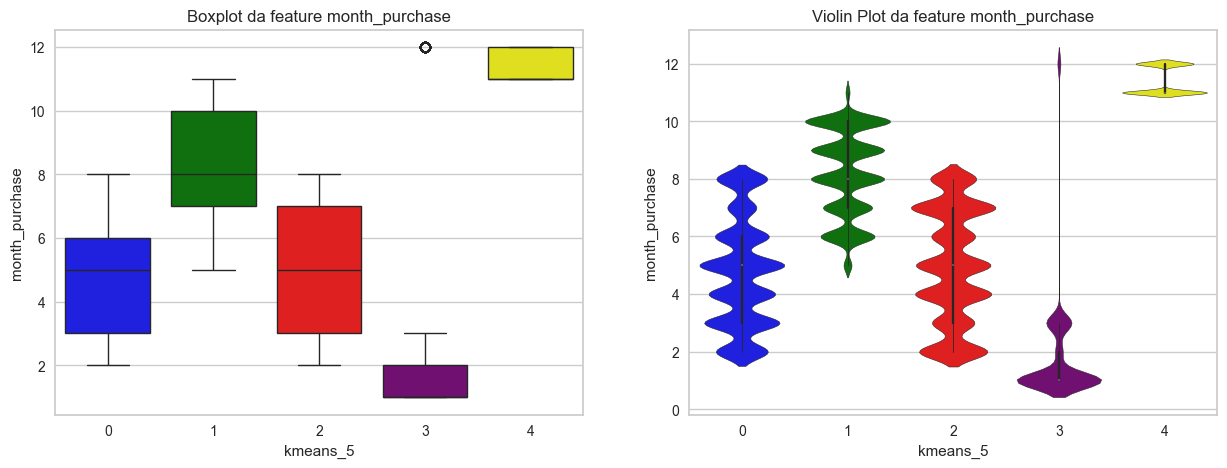

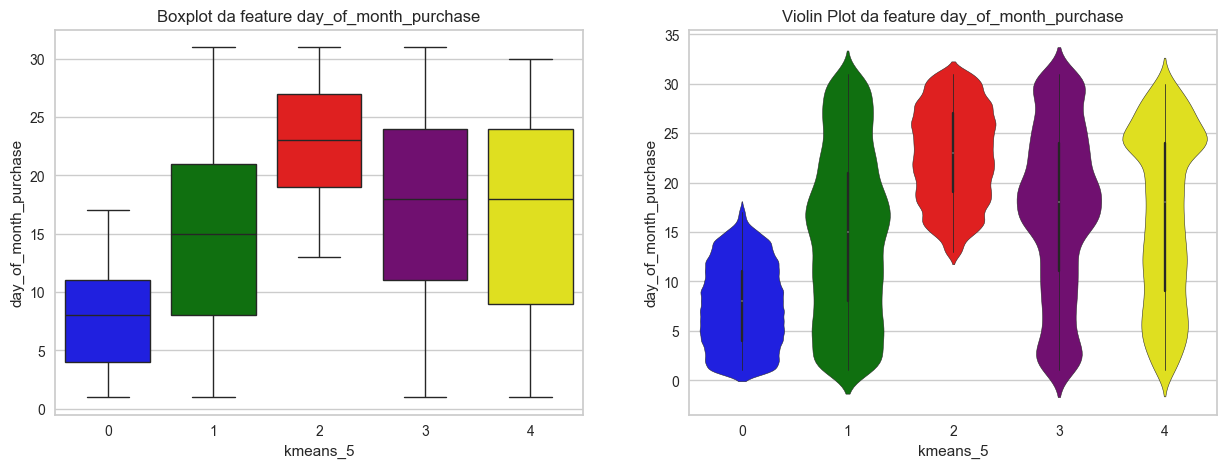

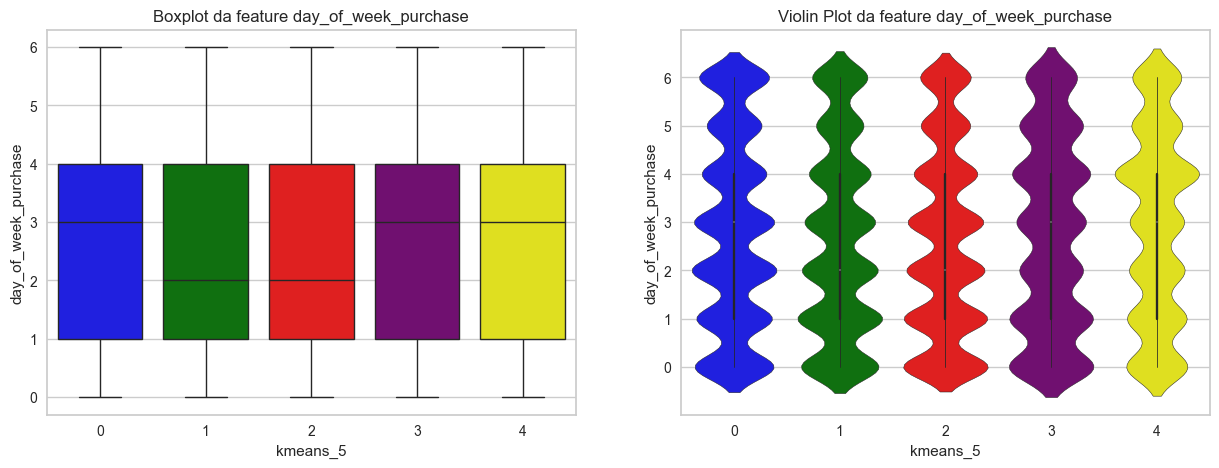

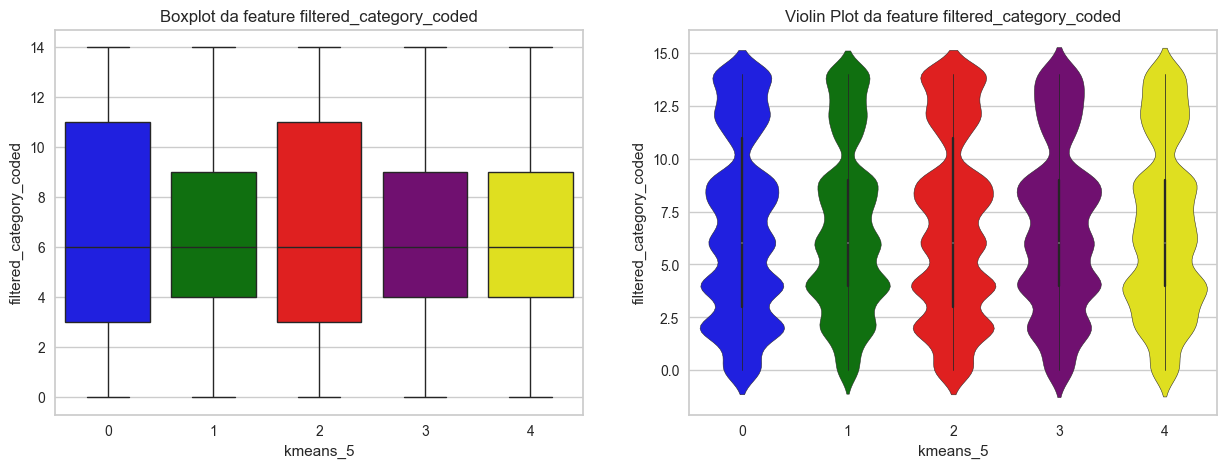

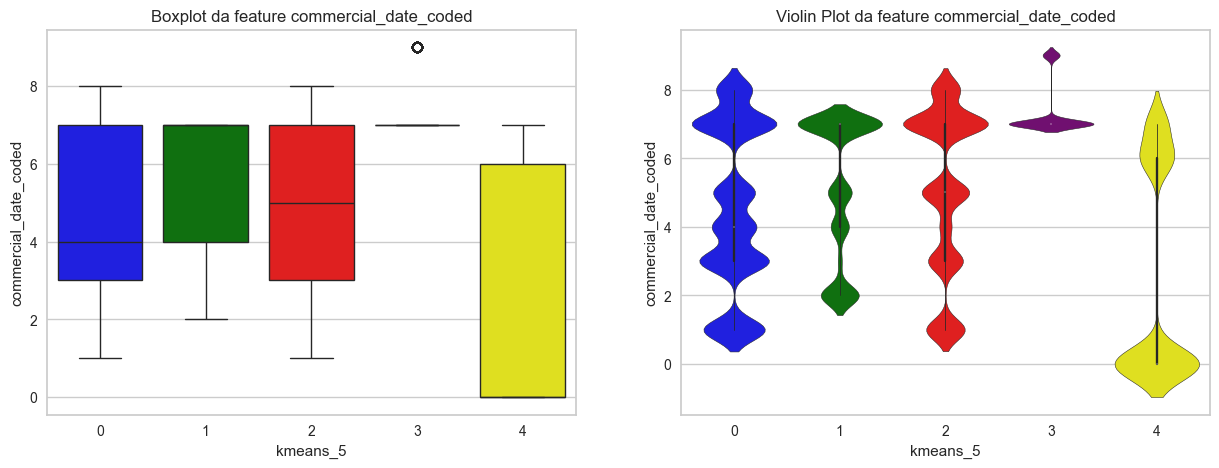

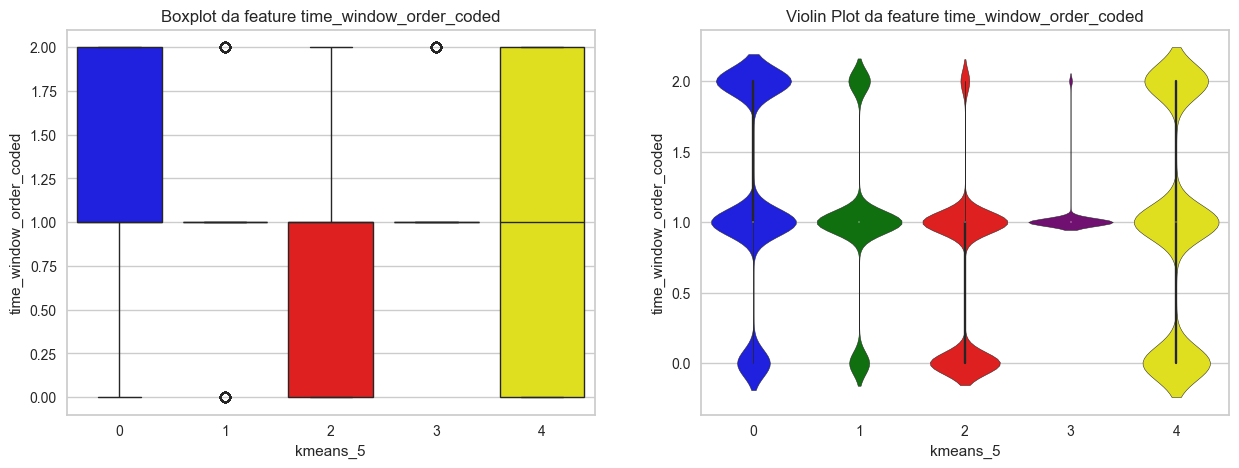

In [23]:
# Célula com longo tempo pra executar

cluster_colors = ['blue', 'green', 'red', 'purple', 'yellow']
clusters_kmeans = [("kmeans_5", 5)]

for column, clusters in clusters_kmeans:
    for cluster in range(clusters):
        # Subset the DataFrame for the current cluster
        cluster_data = df_cluster[df_cluster[column] == cluster]
        df_clean = df_cluster.drop([i[0] for i in clusters_kmeans], axis=1)

        # Plot distributions for each feature
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(df_clean.columns):
            plt.subplot(5, 4, i + 1)
            sns.histplot(cluster_data[feature], kde=True, color=cluster_colors[cluster])
            plt.title(f'{feature} - Cluster {cluster}')
            plt.xlabel('')
            plt.ylabel('')

        plt.tight_layout()
        plt.show()

    for feature in df_clean.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(15, 5)

        sns.boxplot(x=column, y=feature, data=df_cluster, palette=cluster_colors[:clusters], hue=column, legend=False, ax=ax1)
        ax1.set_title(f'Boxplot da feature {feature}') 
        sns.violinplot(x=column, y=feature, data=df_cluster, palette=cluster_colors[:clusters], hue=column, legend=False, ax=ax2)
        ax2.set_title(f'Violin Plot da feature {feature}')
        
        plt.show()

## Resultado da clusterização: 5 clusters


In [24]:
df_cluster.to_parquet("./../data/clean_data/clustered_kmeans_5.parquet")